In [23]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB, quicksum
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statistics

In [24]:
# In a first step, the input prices are loaded. We take day-ahead GErman spot market prices

df = pd.read_csv("./input/Hourly_EV_Charging.csv") # only for index, the actual EV data is handled separatel
df = df.iloc[:8760]

df_price = pd.read_excel("./input/Gro_handelspreise_202101010000_202112312359_Stunde (2).xlsx", skiprows=9)
df_p = pd.DataFrame()
df_p.index = df.index
# MWh prices are transformed to kWh prices
df_p["Deutschland/Luxemburg [€/kWh]"] = df_price["Deutschland/Luxemburg [€/MWh]"].apply(lambda x: x/1000).values
min_price = df_p["Deutschland/Luxemburg [€/kWh]"].min()
df_p["Deutschland/Luxemburg [€/kWh]"] = df_p["Deutschland/Luxemburg [€/kWh]"].apply(lambda x: x+abs(min_price)) # avoid negative values for optimization
df_p.head()

/Users/leosemmelmann/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Deutschland/Luxemburg [€/kWh]
0,0.11987
1,0.11719
2,0.11368
3,0.11192
4,0.10939


In [25]:
# We append a further column to the price dataframe to define the charging hours
df_p.index = df["date"].values[:8760]
df_p.index = pd.to_datetime(df_p.index)
df_p["Hour"] = df_p.index.hour
df_p["Charging Allowed"] = df_p["Hour"].apply(lambda x: 1 if (x<9 or x>19) else 0) # defining when charging is allowed, this is later used in the optimization

# Now, we also load the 1kW nominal capacity PV generation in Hamelin
df_pv = pd.read_csv("./input/ninja_pv_52.1040_9.3562_uncorrected.csv",skiprows=3)


In [138]:
# Here, we load dataframes with 500 EV, HH and HP profiles. The household config decides which configuration per household is selected
df_ev = pd.read_pickle("./input/2019 Hamelin 500 EV.pkl")
df_hh = pd.read_pickle("./input/2019 Hamelin 500 HH.pkl")
df_hp = pd.read_pickle("./input/2019 Hamelin 500 HP.pkl")
household_config = pd.read_pickle("./input/2019 Hamelin Household Configuration.pkl")

In [139]:
# We use this function to later easily access the outputs of the Gurobi model

def get_results_in_df(m, variableNames, n_timesteps): #  "def name(argumente)" zeigt den Anfang einer Funktion an, die ich später beliebig aufrufen kann
   
    results_df = pd.DataFrame(columns = variableNames, index = [t for t in range(n_timesteps)] )   # Hier wird ein leeres DataFrame erstellt, dass als Spalteneinträge die Namen der Gutobi-variablen hat und als Zeilen die Zeitschritte der Entscheidungsvariablen

    for n in variableNames:                                         #Iteration über alle Zielvariablen
        for t in range(n_timesteps):                                #Iteration über alle Zeitschritte
            VarName = n + f"[{t}]"                                  #Hier wird ein String erstellt, der die Form n[t] hat. Mit diesem wird später die Zielvariable ausgelesen
            try:                                                    #try - except ist eine hilfreiche Methdoe, um Fehler abzufangen. Wenn in der nächsten Zeile ein error passiert, bspw. wegen eines Schreibfehlers in meinen zielvariablen, wird die Funktion nicht abgebrochen sondern weiter ausgeführt.
                results_df.loc[t][n] = m.getVarByName(VarName).x    #Auslesen der Zielvaribale
            except:
                pass
            
    return results_df                                               #Hier wird festgelegt, was zurückgegeben wird wenn die Funktion aufgerufen wird. In diesem Fall geben wir das fertige DataFrame mit den ergebnissen der Optimierung zurück

In [206]:
# model settings

# Preparing an empty dataframe to store the results
df_results = pd.DataFrame()
df_results.index = df_p.index

pricing_type = "constant"
operation_type = "constant"

for idx_initial, household in household_config.iloc[:500].iterrows():
    hp_load = df_hp[household["heat_pump_profile"]]
    hh_load = df_hh[household["household_profile"]]
    ev_load = df_ev[household["household_profile"]]
    pv_size = household["pv_power"]
    bess_size = household["bess_capacity"]
    max_bess_power = household["bess_power"]

    # Initialize your environment and model
    env = gp.Env(empty=True)
    env.setParam("OutputFlag", 1)
    env.start()
    model = gp.Model("test", env=env)
    model.setParam('MIPGap', 0.001) 
    length = len(df_p)
    days = int(length/24)


    real_ev_charging = ev_load.apply(lambda x:x/1000).values
    real_ev_charging[-24:] = 0 # setting the last 24 values of ev charging = 0 to avoid model infeasibility
    max_ev_charging = max(real_ev_charging) # maximum ev charge is set at the maximum value
    allowed_charging_hours = df_p["Charging Allowed"].values

    pv_size = bess_size
    pv_load = df_pv["electricity"].apply(lambda x: x*pv_size).values
    min_bess_energy = 0.05*bess_size
    feed_in_tariff = 0.07
    grid_charges = 0.072 # https://www.netze-bw.de/news/veroeffentlichung-vorlaeufiger-netzentgelte
    handling_fee = 0.02 # https://support.tibber.com/de/articles/4406583-wie-setzt-sich-der-monatliche-tibber-preis-zusammen

    
    # either set prices dynamically or static as average wholesale price
    if pricing_type == "dynamic":
        prices = df_p["Deutschland/Luxemburg [€/kWh]"].apply(lambda x: x+grid_charges+handling_fee).values
    elif pricing_type == "constant":
        average_price = df_p["Deutschland/Luxemburg [€/kWh]"].mean()
        prices = np.full(length, average_price+grid_charges+handling_fee)
    else:
        raise ValueError("Pricing type not defined.")
    
    
    # transform hh and hp load to kW
    real_hh_load = hh_load.apply(lambda x:x/1000).values
    real_hp_load = hp_load.apply(lambda x:x/1000).values
    max_hp_load = real_hp_load.max()

    # Initialize variables
    #if operation_type == "dynamic":
    opt_ev_charging = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="p_ch_opt")
    opt_hp_load = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="p_hp_opt")
    opt_bess_charging = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="p_bess_ch_opt")
    opt_bess_discharging = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="p_bess_dch_opt")
    opt_net_energy = model.addVars([t for t in range(length)],lb=0,vtype=GRB.CONTINUOUS,name="opt_net_energy")
    buy_energy = model.addVars(length, vtype=GRB.BINARY, name="buy_energy") # positive when grid intake, zero when feed-out
    e_bess = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="e_bess")


    energy_costs = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS,name = "energy_costs")
    feedin_profits = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS,name = "feedin_profits")

    opt_feed_out_pv = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="opt_feed_out_pv")
    opt_internaluse_pv = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="opt_internaluse_pv")


    block_hp = model.addVars([t for t in range(length)], vtype=gp.GRB.BINARY, name = "blocked_heatpump")


    #### ELECTRIC VEHICLE
    # Ensure that daily charging requirements are met

    if operation_type == "dynamic":
        for idx in range(days):
            idx_start = idx*24
            idx_end = (idx+1)*24
            model.addConstr(quicksum(opt_ev_charging[t]*allowed_charging_hours[t] for t in range(idx_start, idx_end)) == quicksum(real_ev_charging[t] for t in range(idx_start, idx_end)),"daily_charge")


        # Ensure maximum empirical EV charging is never exceeded
        model.addConstrs(opt_ev_charging[t] <= max_ev_charging for t in range(length))

        # Only charging in allowed hours
        model.addConstrs((opt_ev_charging[t] == 0 for t in range(length) if allowed_charging_hours[t] == 0), "no_charging_when_disallowed")
    elif operation_type == "constant":
        model.addConstrs(opt_ev_charging[t] == real_ev_charging[t] for t in range(length))

    #### HEAT PUMP
    # ensure maximum three blocking windows and unblocking for two hours after blocking

    if operation_type == "dynamic":

        for idx in range(days):
            idx_start = idx * 24
            idx_end = (idx + 1) * 24

            # Constraint for maximum three blocks of two hours
            two_hour_blocks = 0
            for t in range(idx_start, idx_end - 1):
                if t < idx_end - 3:
                    two_hour_blocks += model.addVar(vtype=GRB.BINARY)
                    model.addConstr(two_hour_blocks >= block_hp[t] + block_hp[t + 1] - 1)

                    # At least two hours unblock after each block
                    model.addConstr(block_hp[t] + block_hp[t + 1] <= 2 * (1 - block_hp[t + 2]))
                    model.addConstr(block_hp[t] + block_hp[t + 1] <= 2 * (1 - block_hp[t + 3]))

            model.addConstr(two_hour_blocks <= 3, "max_three_blocks_{}".format(idx))

        # ensure that maximum empirical heat pump load is never exceeded and in non-blocking hours at least empirical load
        for t in range(length):
            model.addConstr(opt_hp_load[t]<=max_hp_load)
            model.addConstr((opt_hp_load[t]>=(1-block_hp[t])*real_hp_load[t]))

        # ensure that the daily heat demand is covered
        for idx in range(days):
            idx_start = idx*24
            idx_end = (idx+1)*24
            model.addConstr(quicksum((1-block_hp[t])*opt_hp_load[t] for t in range(idx_start, idx_end)) >= quicksum(real_hp_load[t] for t in range(idx_start, idx_end)), "hp_load_6hr_block_{}".format(idx))


        # ensure that the sum of heat pump load every 6 hours remains in the same range
        for idx in range(days * 4):
            idx_start = idx * 6
            idx_end = (idx + 1) * 6
            if idx_end > length:
                idx_end = length  # Ensure we don't exceed the bounds
            model.addConstr(quicksum(opt_hp_load[t] for t in range(idx_start, idx_end)) >= quicksum(real_hp_load[t] for t in range(idx_start, idx_end)), "hp_load_6hr_block_{}".format(idx))
    
    elif operation_type == "constant":
        model.addConstrs(opt_hp_load[t] == real_hp_load[t] for t in range(length))

    #### BATTERY STORAGE
    model.addConstr(e_bess[0]==min_bess_energy)

    for t in range(length):
        model.addConstr(opt_bess_charging[t] * opt_bess_discharging[t] == 0, "mutual_exclusivity_" + str(t))
        model.addConstr(opt_net_energy[t] * opt_feed_out_pv[t] == 0, "mutual_exclusivity_pv_" + str(t)) # mutual exclusivity for pv feed out and net energy 
        model.addConstr(opt_bess_charging[t]<=max_bess_power)
        model.addConstr(opt_bess_discharging[t]<=max_bess_power)
        model.addConstr(opt_bess_charging[t]<=opt_internaluse_pv[t])


    for t in range(1, length):
        model.addConstr(e_bess[t]==e_bess[t-1]+opt_bess_charging[t-1]-opt_bess_discharging[t-1])
        model.addConstr(e_bess[t]>=min_bess_energy)
        model.addConstr(e_bess[t]<=bess_size)

    ### OPTI
    # calculate net energy of household
    if operation_type == "dynamic":
        model.addConstrs(opt_net_energy[t] == (real_hh_load[t]+opt_ev_charging[t]+opt_bess_charging[t]-opt_bess_discharging[t]+opt_hp_load[t]-opt_internaluse_pv[t])for t in range(length))
    else:
        model.addConstrs(opt_net_energy[t] == (real_hh_load[t]+real_ev_charging[t]+opt_bess_charging[t]-opt_bess_discharging[t]+real_hp_load[t]-opt_internaluse_pv[t])for t in range(length))

    # energy costs
    for t in range(length):
        model.addConstr((opt_internaluse_pv[t]+opt_feed_out_pv[t])==pv_load[t])
        model.addConstr(energy_costs[t] == ((opt_net_energy[t]) * prices[t] ), "calc_energy_costs_" + str(t))
        model.addConstr(feedin_profits[t] == opt_feed_out_pv[t]*feed_in_tariff, "calc_energy_profits_" + str(t))

        # final optimize

    model.setObjective(quicksum(energy_costs[t]-feedin_profits[t] for t in range(length)), GRB.MINIMIZE)
    model.optimize()




    vn = ["opt_net_energy","energy_costs","p_ch_opt","p_hp_opt","blocked_heatpump","p_bess_ch_opt","p_bess_dch_opt","opt_feed_out_pv","opt_internaluse_pv","e_bess"] #Hier müssen die Namen meiner Gurobi-Zielvariablen stehen (siehe Optimeirung)
    n = length
    temp_results = get_results_in_df(model, vn, n)
    df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values




Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xdbeedbd2
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 87762 rows and 83297 columns
Presolve time: 0.27s
Presolved: 17356 rows, 21823 columns, 49240 nonzeros
Variable types: 18653 continuous, 3170 integer (3170 binary)

Root relaxation: objective 2.546504e+03, 11143 iterations, 0.07 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      | 

  RHS range        [5e-04, 1e+01]
Presolve removed 87756 rows and 83304 columns
Presolve time: 0.16s
Presolved: 17362 rows, 21816 columns, 49222 nonzeros
Variable types: 18644 continuous, 3172 integer (3172 binary)

Root relaxation: objective 2.431177e+03, 11124 iterations, 0.08 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2431.17730    0    7          - 2431.17730      -     -    0s
H    0     0                    2431.1772975 2431.17730  0.00%     -    0s

Explored 1 nodes (11124 simplex iterations) in 0.34 seconds (0.35 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 2431.18 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.431177297528e+03, best bound 2.431177297528e+03, gap 0.0000%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to 

Thread count was 8 (of 8 available processors)

Solution count 1: 2369.91 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.369912598361e+03, best bound 2.369912598361e+03, gap 0.0000%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xe2bad53e
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-07, 1e+01]
Presolve removed 87733 rows and 83272 columns
Presolve time: 0.15s
Presolved: 17385 rows, 21848 columns, 49290 nonzeros
Variable types: 186

Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 1e+01]
Presolve removed 87553 rows and 83094 columns
Presolve time: 0.16s
Presolved: 17565 rows, 22026 columns, 49776 nonzeros
Variable types: 18804 continuous, 3222 integer (3222 binary)

Root relaxation: objective 2.316944e+03, 11349 iterations, 0.07 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    2316.9439867 2316.94399  0.00%     -    0s

Explored 1 nodes (11349 simplex iterations) in 0.30 seconds (0.34 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 2316.94 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.316943986715e+03, best bound 2.316943986715e+03, gap 0.0000%
Set parameter Username
Academi

Thread count was 8 (of 8 available processors)

Solution count 1: 1448.59 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.448587720385e+03, best bound 1.448587720385e+03, gap 0.0000%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x0c19e83d
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 1e+01]
Presolve removed 87477 rows and 83016 columns
Presolve time: 0.15s
Presolved: 17641 rows, 22104 columns, 49843 nonzeros
Variable types: 188

Presolve removed 87386 rows and 82931 columns
Presolve time: 0.16s
Presolved: 17732 rows, 22189 columns, 50102 nonzeros
Variable types: 18926 continuous, 3263 integer (3263 binary)

Root relaxation: objective 1.391015e+03, 11533 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1391.01541    0    1          - 1391.01541      -     -    0s
H    0     0                    1391.0154128 1391.01541  0.00%     -    0s

Explored 1 nodes (11533 simplex iterations) in 0.33 seconds (0.37 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 1391.02 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.391015412773e+03, best bound 1.391015412773e+03, gap 0.0000%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.001
Gurobi Optimizer versi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xb36b76b3
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 1e+01]
Presolve removed 87490 rows and 83029 columns
Presolve time: 0.15s
Presolved: 17628 rows, 22091 columns, 49794 nonzeros
Variable types: 18854 continuous, 3237 integer (3237 binary)

Root relaxation: objective 1.404073e+03, 11543 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      | 


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1085.51088    0    1          - 1085.51088      -     -    0s
H    0     0                    1085.5108846 1085.51088  0.00%     -    0s

Explored 1 nodes (11171 simplex iterations) in 0.31 seconds (0.36 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 1085.51 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.085510884568e+03, best bound 1.085510884568e+03, gap 0.0000%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x19304bff
Model has 17520 quadratic constraints
Variable types:

Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-07, 1e+01]
Presolve removed 87564 rows and 83094 columns
Presolve time: 0.15s
Presolved: 17554 rows, 22026 columns, 49588 nonzeros
Variable types: 18808 continuous, 3218 integer (3218 binary)

Root relaxation: objective 1.378299e+03, 11544 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1378.2993915 1378.29939  0.00%     -    0s

Explored 1 nodes (11544 simplex iterations) in 0.30 seconds (0.34 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 1378.3 

Optimal solution found (tolerance 1.00e-03)
Best obj

Thread count was 8 (of 8 available processors)

Solution count 1: 1380.21 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.380214868948e+03, best bound 1.380214868948e+03, gap 0.0000%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x493c379f
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 1e+01]
Presolve removed 87533 rows and 83062 columns
Presolve time: 0.16s
Presolved: 17585 rows, 22058 columns, 49676 nonzeros
Variable types: 188

Presolve removed 87370 rows and 82920 columns
Presolve time: 0.15s
Presolved: 17748 rows, 22200 columns, 50068 nonzeros
Variable types: 18933 continuous, 3267 integer (3267 binary)

Root relaxation: objective 1.279457e+03, 11161 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1279.4567450 1279.45674  0.00%     -    0s

Explored 1 nodes (11161 simplex iterations) in 0.28 seconds (0.32 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 1279.46 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.279456744970e+03, best bound 1.279456744970e+03, gap 0.0000%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x6f4ccaa5
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-07, 1e+01]
Presolve removed 87467 rows and 83019 columns
Presolve time: 0.15s
Presolved: 17651 rows, 22101 columns, 49783 nonzeros
Variable types: 18859 continuous, 3242 integer (3242 binary)

Root relaxation: objective 1.252501e+03, 10972 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1252.5009646 1252.50096  0.00%     -    0s

Explored 1 nodes (10972 simpl

Thread count was 8 (of 8 available processors)

Solution count 1: 1031.91 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.031912752757e+03, best bound 1.031912752757e+03, gap 0.0000%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x1474ccc9
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 1e+01]
Presolve removed 86816 rows and 82371 columns
Presolve time: 0.18s
Presolved: 18302 rows, 22749 columns, 51701 nonzeros
Variable types: 193


Root relaxation: objective 1.181767e+03, 10930 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1181.76670    0    1          - 1181.76670      -     -    0s
H    0     0                    1181.7666991 1181.76670  0.00%     -    0s

Explored 1 nodes (10930 simplex iterations) in 0.31 seconds (0.36 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 1181.77 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.181766699052e+03, best bound 1.181766699052e+03, gap 0.0000%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 n

Model fingerprint: 0x24f2a87e
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 87392 rows and 82937 columns
Presolve time: 0.15s
Presolved: 17726 rows, 22183 columns, 49996 nonzeros
Variable types: 18922 continuous, 3261 integer (3261 binary)

Root relaxation: objective 1.174685e+03, 11122 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1174.68498    0    1          - 1174.68498      -     -    0s
H    0     0                    1174.6849769 1174.68498  0.00%     -    0s

Explored 1 nodes (11122 simplex iterations) in 0.31 seconds (0.36 work units)
Thread count was 8 (of

Thread count was 8 (of 8 available processors)

Solution count 1: 1118.33 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.118332834958e+03, best bound 1.118332834958e+03, gap 0.0000%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xa7fcd6f5
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 1e+01]
Presolve removed 87522 rows and 83054 columns
Presolve time: 0.15s
Presolved: 17596 rows, 22066 columns, 49629 nonzeros
Variable types: 188


Root relaxation: objective 1.048953e+03, 11160 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1048.9527307 1048.95273  0.00%     -    0s

Explored 1 nodes (11160 simplex iterations) in 0.30 seconds (0.33 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 1048.95 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.048952730713e+03, best bound 1.048952730713e+03, gap 0.0000%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x7b8c73d3
Model has 17520 quadratic constraints

Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 1e+01]
Presolve removed 87468 rows and 82965 columns
Presolve time: 0.15s
Presolved: 17650 rows, 22155 columns, 49905 nonzeros
Variable types: 18913 continuous, 3242 integer (3242 binary)

Root relaxation: objective 8.154524e+02, 11298 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     815.4524142  815.45241  0.00%     -    0s

Explored 1 nodes (11298 simplex iterations) in 0.28 seconds (0.32 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 815.452 

Optimal solution found (tolerance 1.00e-03)
Best objective 8.154524142466e+02, best bound

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.001


<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xd156a0a5
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 1e+01]
Presolve removed 87380 rows and 82872 columns
Presolve time: 0.15s
Presolved: 17738 rows, 22248 columns, 50166 nonzeros
Variable types: 18984 continuous, 3264 integer (3264 binary)

Root relaxation: objective 7.772190e+02, 11271 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     777.219

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x01094afa
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-06, 1e+01]
Presolve removed 87393 rows and 82887 columns
Presolve time: 0.15s
Presolved: 17725 rows, 22233 columns, 50134 nonzeros
Variable types: 18972 continuous, 3261 integer (3261 binary)

Root relaxation: objective 7.756801e+02, 11152 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     775.680

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x446e4bc1
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 1e+01]
Presolve removed 87705 rows and 83241 columns
Presolve time: 0.15s
Presolved: 17413 rows, 21879 columns, 49111 nonzeros
Variable types: 18696 continuous, 3183 integer (3183 binary)

Root relaxation: objective 9.471340e+02, 11244 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     947.133

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x6db27736
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 1e+01]
Presolve removed 87799 rows and 83333 columns
Presolve time: 0.15s
Presolved: 17319 rows, 21787 columns, 48837 nonzeros
Variable types: 18628 continuous, 3159 integer (3159 binary)

Root relaxation: objective 9.438345e+02, 11072 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     943.834

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xc9b3b845
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-05, 1e+01]
Presolve removed 87804 rows and 83331 columns
Presolve time: 0.15s
Presolved: 17314 rows, 21789 columns, 48829 nonzeros
Variable types: 18631 continuous, 3158 integer (3158 binary)

Root relaxation: objective 9.324029e+02, 11251 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     932.402

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x067e3a7a
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 1e+01]
Presolve removed 87788 rows and 83322 columns
Presolve time: 0.15s
Presolved: 17330 rows, 21798 columns, 48859 nonzeros
Variable types: 18635 continuous, 3163 integer (3163 binary)

Root relaxation: objective 9.306421e+02, 11154 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     930.642

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xf4296e90
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 1e+01]
Presolve removed 87760 rows and 83283 columns
Presolve time: 0.15s
Presolved: 17358 rows, 21837 columns, 48967 nonzeros
Variable types: 18668 continuous, 3169 integer (3169 binary)

Root relaxation: objective 9.496444e+02, 12138 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     949.644

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x6af6f9fa
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 1e+01]
Presolve removed 87755 rows and 83291 columns
Presolve time: 0.15s
Presolved: 17363 rows, 21829 columns, 48947 nonzeros
Variable types: 18659 continuous, 3170 integer (3170 binary)

Root relaxation: objective 9.214843e+02, 11249 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     921.484

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x0182e2aa
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 1e+01]
Presolve removed 87804 rows and 83340 columns
Presolve time: 0.15s
Presolved: 17314 rows, 21780 columns, 48810 nonzeros
Variable types: 18622 continuous, 3158 integer (3158 binary)

Root relaxation: objective 9.114428e+02, 11064 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     911.442

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xe145276b
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 1e+01]
Presolve removed 87485 rows and 82983 columns
Presolve time: 0.15s
Presolved: 17633 rows, 22137 columns, 49839 nonzeros
Variable types: 18899 continuous, 3238 integer (3238 binary)

Root relaxation: objective 7.334443e+02, 11031 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     733.444

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x427ec993
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 1e+01]
Presolve removed 87522 rows and 83005 columns
Presolve time: 0.15s
Presolved: 17596 rows, 22115 columns, 49739 nonzeros
Variable types: 18886 continuous, 3229 integer (3229 binary)

Root relaxation: objective 7.657797e+02, 11173 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     765.779

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x598cbac6
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 1e+01]
Presolve removed 87741 rows and 83276 columns
Presolve time: 0.15s
Presolved: 17377 rows, 21844 columns, 49006 nonzeros
Variable types: 18670 continuous, 3174 integer (3174 binary)

Root relaxation: objective 8.914027e+02, 11205 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  891.40269    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xebed2a86
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 1e+01]
Presolve removed 87374 rows and 82858 columns
Presolve time: 0.15s
Presolved: 17744 rows, 22262 columns, 50185 nonzeros
Variable types: 18996 continuous, 3266 integer (3266 binary)

Root relaxation: objective 7.305832e+02, 11221 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     730.583

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x76240b0d
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 1e+01]
Presolve removed 87359 rows and 82842 columns
Presolve time: 0.15s
Presolved: 17759 rows, 22278 columns, 50215 nonzeros
Variable types: 19008 continuous, 3270 integer (3270 binary)

Root relaxation: objective 7.240083e+02, 11275 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     724.008

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x6615298a
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 1e+01]
Presolve removed 87515 rows and 83009 columns
Presolve time: 0.15s
Presolved: 17603 rows, 22111 columns, 49762 nonzeros
Variable types: 18880 continuous, 3231 integer (3231 binary)

Root relaxation: objective 7.557161e+02, 11100 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  755.71609    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x660116ae
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 1e+01]
Presolve removed 87407 rows and 82901 columns
Presolve time: 0.15s
Presolved: 17711 rows, 22219 columns, 50054 nonzeros
Variable types: 18961 continuous, 3258 integer (3258 binary)

Root relaxation: objective 7.239029e+02, 11092 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  723.90288    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x1e7bc3e5
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 1e+01]
Presolve removed 87412 rows and 82906 columns
Presolve time: 0.15s
Presolved: 17706 rows, 22214 columns, 50046 nonzeros
Variable types: 18956 continuous, 3258 integer (3258 binary)

Root relaxation: objective 7.262213e+02, 11155 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     726.221

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xbe98ec9b
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 8e+00]
Presolve removed 87294 rows and 82875 columns
Presolve time: 0.15s
Presolved: 17824 rows, 22245 columns, 50315 nonzeros
Variable types: 18958 continuous, 3287 integer (3287 binary)

Root relaxation: objective 1.112796e+03, 10846 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1112.795

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x549b9e58
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+00]
Presolve removed 87595 rows and 83115 columns
Presolve time: 0.15s
Presolved: 17523 rows, 22005 columns, 49619 nonzeros
Variable types: 18793 continuous, 3212 integer (3212 binary)

Root relaxation: objective 1.124034e+03, 10573 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1124.03427    0    3       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x7f6070f5
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 7e+00]
Presolve removed 87637 rows and 83159 columns
Presolve time: 0.15s
Presolved: 17481 rows, 21961 columns, 49490 nonzeros
Variable types: 18758 continuous, 3203 integer (3203 binary)

Root relaxation: objective 1.106031e+03, 11069 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1106.03138    0    5       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xb40a4eae
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 7e+00]
Presolve removed 87422 rows and 82956 columns
Presolve time: 0.15s
Presolved: 17696 rows, 22164 columns, 50112 nonzeros
Variable types: 18908 continuous, 3256 integer (3256 binary)

Root relaxation: objective 1.080858e+03, 10633 iterations, 0.07 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1080.85813    0    6       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xcd16a0c5
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 8e+00]
Presolve removed 87875 rows and 83432 columns
Presolve time: 0.15s
Presolved: 17243 rows, 21688 columns, 48670 nonzeros
Variable types: 18545 continuous, 3143 integer (3143 binary)

Root relaxation: objective 1.226598e+03, 10428 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1226.59841    0    5       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x3b289722
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 7e+00]
Presolve removed 87453 rows and 82980 columns
Presolve time: 0.15s
Presolved: 17665 rows, 22140 columns, 50000 nonzeros
Variable types: 18893 continuous, 3247 integer (3247 binary)

Root relaxation: objective 1.093133e+03, 10563 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1093.13269    0    3       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x73b4a5f9
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 9e+00]
Presolve removed 87832 rows and 83380 columns
Presolve time: 0.15s
Presolved: 17286 rows, 21740 columns, 48804 nonzeros
Variable types: 18587 continuous, 3153 integer (3153 binary)

Root relaxation: objective 1.218670e+03, 10635 iterations, 0.08 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1218.67013    0    5       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x55d2a058
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 8e+00]
Presolve removed 87290 rows and 82871 columns
Presolve time: 0.15s
Presolved: 17828 rows, 22249 columns, 50324 nonzeros
Variable types: 18961 continuous, 3288 integer (3288 binary)

Root relaxation: objective 1.082925e+03, 10719 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1082.925

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x7cc37da0
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+00]
Presolve removed 87523 rows and 83055 columns
Presolve time: 0.15s
Presolved: 17595 rows, 22065 columns, 49804 nonzeros
Variable types: 18834 continuous, 3231 integer (3231 binary)

Root relaxation: objective 1.077970e+03, 10547 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1077.97025    0    2       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x6a737b35
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-06, 8e+00]
Presolve removed 87235 rows and 82821 columns
Presolve time: 0.15s
Presolved: 17883 rows, 22299 columns, 50481 nonzeros
Variable types: 18994 continuous, 3305 integer (3305 binary)

Root relaxation: objective 1.079748e+03, 10540 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1079.74765    0    4       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xca2445ea
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 8e+00]
Presolve removed 87938 rows and 83483 columns
Presolve time: 0.15s
Presolved: 17180 rows, 21637 columns, 48507 nonzeros
Variable types: 18512 continuous, 3125 integer (3125 binary)

Root relaxation: objective 1.225982e+03, 10484 iterations, 0.07 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1225.98215    0    5       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xb1564dda
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 8e+00]
Presolve removed 87160 rows and 82742 columns
Presolve time: 0.15s
Presolved: 17958 rows, 22378 columns, 50689 nonzeros
Variable types: 19055 continuous, 3323 integer (3323 binary)

Root relaxation: objective 1.047589e+03, 10772 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1047.589

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x5df4c85d
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 7e+00]
Presolve removed 87266 rows and 82848 columns
Presolve time: 0.15s
Presolved: 17852 rows, 22272 columns, 50391 nonzeros
Variable types: 18979 continuous, 3293 integer (3293 binary)

Root relaxation: objective 1.050062e+03, 10766 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1050.061

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xc8fc38d5
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-06, 8e+00]
Presolve removed 87108 rows and 82688 columns
Presolve time: 0.16s
Presolved: 18010 rows, 22432 columns, 50844 nonzeros
Variable types: 19099 continuous, 3333 integer (3333 binary)

Root relaxation: objective 1.047104e+03, 10901 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1047.103

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xd5cc32b9
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 8e+00]
Presolve removed 87304 rows and 82886 columns
Presolve time: 0.17s
Presolved: 17814 rows, 22234 columns, 50274 nonzeros
Variable types: 18951 continuous, 3283 integer (3283 binary)

Root relaxation: objective 1.053442e+03, 10770 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1053.442

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x50e50642
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 8e+00]
Presolve removed 87237 rows and 82810 columns
Presolve time: 0.15s
Presolved: 17881 rows, 22310 columns, 50483 nonzeros
Variable types: 19010 continuous, 3300 integer (3300 binary)

Root relaxation: objective 1.028626e+03, 10867 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1028.626

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x1f4a96b0
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 7e+00]
Presolve removed 87372 rows and 82890 columns
Presolve time: 0.15s
Presolved: 17746 rows, 22230 columns, 50255 nonzeros
Variable types: 18963 continuous, 3267 integer (3267 binary)

Root relaxation: objective 1.030969e+03, 10827 iterations, 0.07 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1030.96890    0    6       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xe3e651c4
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 7e+00]
Presolve removed 87208 rows and 82793 columns
Presolve time: 0.15s
Presolved: 17910 rows, 22327 columns, 50545 nonzeros
Variable types: 19017 continuous, 3310 integer (3310 binary)

Root relaxation: objective 1.018247e+03, 10856 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1018.246

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x9d7cb15f
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 8e+00]
Presolve removed 87120 rows and 82708 columns
Presolve time: 0.15s
Presolved: 17998 rows, 22412 columns, 50790 nonzeros
Variable types: 19082 continuous, 3330 integer (3330 binary)

Root relaxation: objective 1.020422e+03, 10981 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1020.421

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xce40debf
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87398 rows and 82925 columns
Presolve time: 0.15s
Presolved: 17720 rows, 22195 columns, 50159 nonzeros
Variable types: 18933 continuous, 3262 integer (3262 binary)

Root relaxation: objective 1.031429e+03, 10848 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1031.42866    0    4       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xc8e29e26
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 8e+00]
Presolve removed 87150 rows and 82726 columns
Presolve time: 0.15s
Presolved: 17968 rows, 22394 columns, 50718 nonzeros
Variable types: 19070 continuous, 3324 integer (3324 binary)

Root relaxation: objective 1.017418e+03, 10840 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1017.417

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xb9826703
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 8e+00]
Presolve removed 87158 rows and 82742 columns
Presolve time: 0.15s
Presolved: 17960 rows, 22378 columns, 50685 nonzeros
Variable types: 19056 continuous, 3322 integer (3322 binary)

Root relaxation: objective 1.005844e+03, 10819 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1005.843

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x6ca620b6
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-05, 7e+00]
Presolve removed 87329 rows and 82859 columns
Presolve time: 0.15s
Presolved: 17789 rows, 22261 columns, 50256 nonzeros
Variable types: 18984 continuous, 3277 integer (3277 binary)

Root relaxation: objective 1.133746e+03, 11355 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1133.745

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x16e2148c
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-06, 7e+00]
Presolve removed 86670 rows and 82287 columns
Presolve time: 0.15s
Presolved: 18448 rows, 22833 columns, 52102 nonzeros
Variable types: 19390 continuous, 3443 integer (3443 binary)

Root relaxation: objective 8.930048e+02, 11469 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     893.004

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x0354a712
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-05, 8e+00]
Presolve removed 87069 rows and 82652 columns
Presolve time: 0.16s
Presolved: 18049 rows, 22468 columns, 50933 nonzeros
Variable types: 19124 continuous, 3344 integer (3344 binary)

Root relaxation: objective 1.006517e+03, 10948 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1006.517

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x5792c3c9
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-07, 7e+00]
Presolve removed 86805 rows and 82421 columns
Presolve time: 0.17s
Presolved: 18313 rows, 22699 columns, 51708 nonzeros
Variable types: 19291 continuous, 3408 integer (3408 binary)

Root relaxation: objective 9.037146e+02, 11339 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     903.714

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xd09e4415
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 7e+00]
Presolve removed 87374 rows and 82899 columns
Presolve time: 0.21s
Presolved: 17744 rows, 22221 columns, 50125 nonzeros
Variable types: 18955 continuous, 3266 integer (3266 binary)

Root relaxation: objective 1.121703e+03, 11211 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1121.703

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xf18bcd65
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 7e+00]
Presolve removed 87088 rows and 82667 columns
Presolve time: 0.15s
Presolved: 18030 rows, 22453 columns, 50898 nonzeros
Variable types: 19116 continuous, 3337 integer (3337 binary)

Root relaxation: objective 9.904863e+02, 10867 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     990.486

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x5d40e010
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-06, 8e+00]
Presolve removed 87235 rows and 82813 columns
Presolve time: 0.15s
Presolved: 17883 rows, 22307 columns, 50472 nonzeros
Variable types: 19005 continuous, 3302 integer (3302 binary)

Root relaxation: objective 1.003858e+03, 10792 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1003.857

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xe92bbe3f
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 7e+00]
Presolve removed 87325 rows and 82850 columns
Presolve time: 0.15s
Presolved: 17793 rows, 22270 columns, 50267 nonzeros
Variable types: 18992 continuous, 3278 integer (3278 binary)

Root relaxation: objective 1.122589e+03, 11149 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1122.589

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xf9d4aeb9
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 7e+00]
Presolve removed 87344 rows and 82872 columns
Presolve time: 0.15s
Presolved: 17774 rows, 22248 columns, 50205 nonzeros
Variable types: 18973 continuous, 3275 integer (3275 binary)

Root relaxation: objective 1.108545e+03, 11159 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1108.544

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xa9e7a56b
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87514 rows and 83033 columns
Presolve time: 0.16s
Presolved: 17604 rows, 22087 columns, 49825 nonzeros
Variable types: 18855 continuous, 3232 integer (3232 binary)

Root relaxation: objective 1.004398e+03, 10516 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1004.39756    0    6       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x74be753b
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 7e+00]
Presolve removed 87164 rows and 82744 columns
Presolve time: 0.15s
Presolved: 17954 rows, 22376 columns, 50673 nonzeros
Variable types: 19057 continuous, 3319 integer (3319 binary)

Root relaxation: objective 9.826982e+02, 10906 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     982.698

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x4fcb9078
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 8e+00]
Presolve removed 87212 rows and 82794 columns
Presolve time: 0.15s
Presolved: 17906 rows, 22326 columns, 50528 nonzeros
Variable types: 19020 continuous, 3306 integer (3306 binary)

Root relaxation: objective 9.881903e+02, 10799 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     988.190

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x5180b12a
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 8e+00]
Presolve removed 87184 rows and 82759 columns
Presolve time: 0.15s
Presolved: 17934 rows, 22361 columns, 50616 nonzeros
Variable types: 19048 continuous, 3313 integer (3313 binary)

Root relaxation: objective 9.913116e+02, 10762 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     991.311

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x1557ecbd
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 7e+00]
Presolve removed 86716 rows and 82330 columns
Presolve time: 0.15s
Presolved: 18402 rows, 22790 columns, 51956 nonzeros
Variable types: 19359 continuous, 3431 integer (3431 binary)

Root relaxation: objective 8.834659e+02, 11347 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     883.465

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xe8daaf35
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 8e+00]
Presolve removed 87172 rows and 82757 columns
Presolve time: 0.15s
Presolved: 17946 rows, 22363 columns, 50654 nonzeros
Variable types: 19045 continuous, 3318 integer (3318 binary)

Root relaxation: objective 9.788422e+02, 10799 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     978.842

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x89234c76
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 7e+00]
Presolve removed 87204 rows and 82787 columns
Presolve time: 0.15s
Presolved: 17914 rows, 22333 columns, 50553 nonzeros
Variable types: 19024 continuous, 3309 integer (3309 binary)

Root relaxation: objective 9.848168e+02, 10957 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     984.816

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xd52269ce
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-05, 7e+00]
Presolve removed 87341 rows and 82861 columns
Presolve time: 0.16s
Presolved: 17777 rows, 22259 columns, 50234 nonzeros
Variable types: 18985 continuous, 3274 integer (3274 binary)

Root relaxation: objective 1.104500e+03, 11315 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1104.500

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xf1e8f580
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 86889 rows and 82488 columns
Presolve time: 0.15s
Presolved: 18229 rows, 22632 columns, 51476 nonzeros
Variable types: 19244 continuous, 3388 integer (3388 binary)

Root relaxation: objective 8.916928e+02, 11123 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     891.692

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xef8a2032
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 7e+00]
Presolve removed 87256 rows and 82779 columns
Presolve time: 0.15s
Presolved: 17862 rows, 22341 columns, 50464 nonzeros
Variable types: 19046 continuous, 3295 integer (3295 binary)

Root relaxation: objective 1.098037e+03, 11295 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1098.036

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x6859de8c
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 7e+00]
Presolve removed 86839 rows and 82443 columns
Presolve time: 0.15s
Presolved: 18279 rows, 22677 columns, 51605 nonzeros
Variable types: 19277 continuous, 3400 integer (3400 binary)

Root relaxation: objective 8.961013e+02, 11288 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     896.101

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x61b1a73f
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87373 rows and 82889 columns
Presolve time: 0.15s
Presolved: 17745 rows, 22231 columns, 50125 nonzeros
Variable types: 18964 continuous, 3267 integer (3267 binary)

Root relaxation: objective 1.107985e+03, 11158 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1107.984

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x9a0dc7dd
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 7e+00]
Presolve removed 86821 rows and 82429 columns
Presolve time: 0.16s
Presolved: 18297 rows, 22691 columns, 51669 nonzeros
Variable types: 19286 continuous, 3405 integer (3405 binary)

Root relaxation: objective 8.851165e+02, 11302 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     885.116

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xc52542b5
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 8e+00]
Presolve removed 87144 rows and 82721 columns
Presolve time: 0.15s
Presolved: 17974 rows, 22399 columns, 50728 nonzeros
Variable types: 19075 continuous, 3324 integer (3324 binary)

Root relaxation: objective 9.733501e+02, 10876 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     973.350

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xce38f06b
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-06, 7e+00]
Presolve removed 86723 rows and 82340 columns
Presolve time: 0.15s
Presolved: 18395 rows, 22780 columns, 51945 nonzeros
Variable types: 19351 continuous, 3429 integer (3429 binary)

Root relaxation: objective 8.601215e+02, 11352 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     860.121

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x53271216
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 7e+00]
Presolve removed 87378 rows and 82904 columns
Presolve time: 0.15s
Presolved: 17740 rows, 22216 columns, 50115 nonzeros
Variable types: 18950 continuous, 3266 integer (3266 binary)

Root relaxation: objective 1.100855e+03, 11128 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1100.854

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xfdb99438
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 7e+00]
Presolve removed 86856 rows and 82470 columns
Presolve time: 0.15s
Presolved: 18262 rows, 22650 columns, 51560 nonzeros
Variable types: 19254 continuous, 3396 integer (3396 binary)

Root relaxation: objective 8.676093e+02, 11159 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     867.609

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x1c27e65c
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-06, 7e+00]
Presolve removed 86742 rows and 82347 columns
Presolve time: 0.15s
Presolved: 18376 rows, 22773 columns, 51910 nonzeros
Variable types: 19349 continuous, 3424 integer (3424 binary)

Root relaxation: objective 8.650403e+02, 11340 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     865.040

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x539a95bc
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-06, 7e+00]
Presolve removed 86836 rows and 82445 columns
Presolve time: 0.15s
Presolved: 18282 rows, 22675 columns, 51617 nonzeros
Variable types: 19275 continuous, 3400 integer (3400 binary)

Root relaxation: objective 8.634725e+02, 11373 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     863.472

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xf58d8bfa
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 7e+00]
Presolve removed 86803 rows and 82409 columns
Presolve time: 0.15s
Presolved: 18315 rows, 22711 columns, 51715 nonzeros
Variable types: 19303 continuous, 3408 integer (3408 binary)

Root relaxation: objective 8.533055e+02, 11275 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     853.305

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xa4e6b23d
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 7e+00]
Presolve removed 86902 rows and 82505 columns
Presolve time: 0.16s
Presolved: 18216 rows, 22615 columns, 51442 nonzeros
Variable types: 19231 continuous, 3384 integer (3384 binary)

Root relaxation: objective 8.617664e+02, 11181 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     861.766

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xbccd52cd
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 7e+00]
Presolve removed 86876 rows and 82484 columns
Presolve time: 0.15s
Presolved: 18242 rows, 22636 columns, 51515 nonzeros
Variable types: 19246 continuous, 3390 integer (3390 binary)

Root relaxation: objective 8.572192e+02, 11160 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     857.219

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x51064fcf
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 7e+00]
Presolve removed 86738 rows and 82345 columns
Presolve time: 0.15s
Presolved: 18380 rows, 22775 columns, 51909 nonzeros
Variable types: 19349 continuous, 3426 integer (3426 binary)

Root relaxation: objective 8.447498e+02, 11328 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     844.749

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xb83619b5
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-05, 7e+00]
Presolve removed 87342 rows and 82870 columns
Presolve time: 0.15s
Presolved: 17776 rows, 22250 columns, 50213 nonzeros
Variable types: 18976 continuous, 3274 integer (3274 binary)

Root relaxation: objective 1.069124e+03, 11192 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1069.123

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xb74c677b
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87454 rows and 82977 columns
Presolve time: 0.15s
Presolved: 17664 rows, 22143 columns, 49886 nonzeros
Variable types: 18897 continuous, 3246 integer (3246 binary)

Root relaxation: objective 1.086585e+03, 11100 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1086.585

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xdb81f9f2
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87284 rows and 82804 columns
Presolve time: 0.16s
Presolved: 17834 rows, 22316 columns, 50371 nonzeros
Variable types: 19028 continuous, 3288 integer (3288 binary)

Root relaxation: objective 1.051965e+03, 11346 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1051.964

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xa48eec90
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-07, 7e+00]
Presolve removed 87257 rows and 82780 columns
Presolve time: 0.15s
Presolved: 17861 rows, 22340 columns, 50449 nonzeros
Variable types: 19045 continuous, 3295 integer (3295 binary)

Root relaxation: objective 1.047254e+03, 11317 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1047.253

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x0c82105b
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 7e+00]
Presolve removed 86753 rows and 82363 columns
Presolve time: 0.15s
Presolved: 18365 rows, 22757 columns, 51854 nonzeros
Variable types: 19336 continuous, 3421 integer (3421 binary)

Root relaxation: objective 8.332301e+02, 11351 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     833.230

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x29e75f66
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 7e+00]
Presolve removed 86816 rows and 82418 columns
Presolve time: 0.15s
Presolved: 18302 rows, 22702 columns, 51688 nonzeros
Variable types: 19297 continuous, 3405 integer (3405 binary)

Root relaxation: objective 8.446683e+02, 11423 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     844.668

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xa5042bb5
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-07, 7e+00]
Presolve removed 87412 rows and 82937 columns
Presolve time: 0.15s
Presolved: 17706 rows, 22183 columns, 50012 nonzeros
Variable types: 18927 continuous, 3256 integer (3256 binary)

Root relaxation: objective 1.061804e+03, 11084 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1061.804

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x476091a8
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 86804 rows and 82395 columns
Presolve time: 0.16s
Presolved: 18314 rows, 22725 columns, 51729 nonzeros
Variable types: 19317 continuous, 3408 integer (3408 binary)

Root relaxation: objective 8.499348e+02, 11208 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     849.934

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x11f9491e
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+00]
Presolve removed 87378 rows and 82902 columns
Presolve time: 0.15s
Presolved: 17740 rows, 22218 columns, 50099 nonzeros
Variable types: 18952 continuous, 3266 integer (3266 binary)

Root relaxation: objective 1.054762e+03, 11205 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1054.761

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x2f2c3a75
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-05, 7e+00]
Presolve removed 87432 rows and 82949 columns
Presolve time: 0.15s
Presolved: 17686 rows, 22171 columns, 49941 nonzeros
Variable types: 18920 continuous, 3251 integer (3251 binary)

Root relaxation: objective 1.067791e+03, 10883 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1067.790

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x1ba949e1
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 7e+00]
Presolve removed 86798 rows and 82396 columns
Presolve time: 0.15s
Presolved: 18320 rows, 22724 columns, 51734 nonzeros
Variable types: 19314 continuous, 3410 integer (3410 binary)

Root relaxation: objective 8.363935e+02, 11266 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     836.393

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xea948fbc
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 7e+00]
Presolve removed 87441 rows and 82961 columns
Presolve time: 0.15s
Presolved: 17677 rows, 22159 columns, 49917 nonzeros
Variable types: 18910 continuous, 3249 integer (3249 binary)

Root relaxation: objective 1.061285e+03, 11054 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1061.285

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xcad60309
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 7e+00]
Presolve removed 87409 rows and 82923 columns
Presolve time: 0.15s
Presolved: 17709 rows, 22197 columns, 50015 nonzeros
Variable types: 18940 continuous, 3257 integer (3257 binary)

Root relaxation: objective 1.049630e+03, 11180 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1049.629

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x1740dcd3
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 86843 rows and 82444 columns
Presolve time: 0.16s
Presolved: 18275 rows, 22676 columns, 51600 nonzeros
Variable types: 19277 continuous, 3399 integer (3399 binary)

Root relaxation: objective 8.139932e+02, 11210 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     813.993

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x89b6e010
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+00]
Presolve removed 87432 rows and 82960 columns
Presolve time: 0.15s
Presolved: 17686 rows, 22160 columns, 49930 nonzeros
Variable types: 18909 continuous, 3251 integer (3251 binary)

Root relaxation: objective 1.040731e+03, 10995 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1040.730

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xa0f989b5
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 7e+00]
Presolve removed 86813 rows and 82402 columns
Presolve time: 0.15s
Presolved: 18305 rows, 22718 columns, 51706 nonzeros
Variable types: 19311 continuous, 3407 integer (3407 binary)

Root relaxation: objective 8.096650e+02, 11280 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     809.664

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x4e6d984d
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 7e+00]
Presolve removed 87460 rows and 82980 columns
Presolve time: 0.15s
Presolved: 17658 rows, 22140 columns, 49872 nonzeros
Variable types: 18895 continuous, 3245 integer (3245 binary)

Root relaxation: objective 1.026897e+03, 11085 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1026.896

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xfa950abe
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-05, 7e+00]
Presolve removed 87440 rows and 82955 columns
Presolve time: 0.16s
Presolved: 17678 rows, 22165 columns, 49924 nonzeros
Variable types: 18916 continuous, 3249 integer (3249 binary)

Root relaxation: objective 1.020603e+03, 11019 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1020.602

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x88447682
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87360 rows and 82871 columns
Presolve time: 0.15s
Presolved: 17758 rows, 22249 columns, 50179 nonzeros
Variable types: 18980 continuous, 3269 integer (3269 binary)

Root relaxation: objective 1.017918e+03, 11210 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1017.917

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xd3452b11
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-07, 7e+00]
Presolve removed 87508 rows and 83029 columns
Presolve time: 0.16s
Presolved: 17610 rows, 22091 columns, 49720 nonzeros
Variable types: 18859 continuous, 3232 integer (3232 binary)

Root relaxation: objective 1.013319e+03, 11062 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1013.318

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xc6d92519
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+00]
Presolve removed 86810 rows and 82410 columns
Presolve time: 0.15s
Presolved: 18308 rows, 22710 columns, 51696 nonzeros
Variable types: 19303 continuous, 3407 integer (3407 binary)

Root relaxation: objective 7.936144e+02, 11321 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     793.614

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x194c17c2
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-05, 7e+00]
Presolve removed 86877 rows and 82472 columns
Presolve time: 0.15s
Presolved: 18241 rows, 22648 columns, 51497 nonzeros
Variable types: 19257 continuous, 3391 integer (3391 binary)

Root relaxation: objective 7.733052e+02, 11270 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     773.305

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x4341e2da
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-07, 7e+00]
Presolve removed 87462 rows and 82980 columns
Presolve time: 0.15s
Presolved: 17656 rows, 22140 columns, 49858 nonzeros
Variable types: 18896 continuous, 3244 integer (3244 binary)

Root relaxation: objective 9.849073e+02, 11047 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     984.907

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x00c0a84d
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 7e+00]
Presolve removed 87420 rows and 82942 columns
Presolve time: 0.20s
Presolved: 17698 rows, 22178 columns, 50000 nonzeros
Variable types: 18924 continuous, 3254 integer (3254 binary)

Root relaxation: objective 7.865083e+02, 10942 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     786.508

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xaaec2fc6
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 7e+00]
Presolve removed 87464 rows and 82977 columns
Presolve time: 0.15s
Presolved: 17654 rows, 22143 columns, 49879 nonzeros
Variable types: 18898 continuous, 3245 integer (3245 binary)

Root relaxation: objective 7.917765e+02, 10972 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     791.776

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xea5704d7
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-06, 7e+00]
Presolve removed 87336 rows and 82843 columns
Presolve time: 0.15s
Presolved: 17782 rows, 22277 columns, 50259 nonzeros
Variable types: 19002 continuous, 3275 integer (3275 binary)

Root relaxation: objective 7.675281e+02, 10832 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     767.528

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x529ebb93
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+00]
Presolve removed 87276 rows and 82830 columns
Presolve time: 0.15s
Presolved: 17842 rows, 22290 columns, 50382 nonzeros
Variable types: 19000 continuous, 3290 integer (3290 binary)

Root relaxation: objective 6.959663e+02, 10770 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     695.966

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x26a18a7e
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+00]
Presolve removed 87450 rows and 82969 columns
Presolve time: 0.16s
Presolved: 17668 rows, 22151 columns, 49912 nonzeros
Variable types: 18904 continuous, 3247 integer (3247 binary)

Root relaxation: objective 7.563859e+02, 10827 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     756.385

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xe3a4e05f
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-05, 7e+00]
Presolve removed 87201 rows and 82762 columns
Presolve time: 0.15s
Presolved: 17917 rows, 22358 columns, 50594 nonzeros
Variable types: 19049 continuous, 3309 integer (3309 binary)

Root relaxation: objective 6.765296e+02, 10824 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     676.529

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x9b1d7adb
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 7e+00]
Presolve removed 87337 rows and 82899 columns
Presolve time: 0.15s
Presolved: 17781 rows, 22221 columns, 50203 nonzeros
Variable types: 18946 continuous, 3275 integer (3275 binary)

Root relaxation: objective 6.909355e+02, 10532 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  690.93547    0    8       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xc61da06c
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87259 rows and 82817 columns
Presolve time: 0.15s
Presolved: 17859 rows, 22303 columns, 50417 nonzeros
Variable types: 19008 continuous, 3295 integer (3295 binary)

Root relaxation: objective 6.820833e+02, 10828 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     682.083

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xf31978f1
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-07, 7e+00]
Presolve removed 87448 rows and 82955 columns
Presolve time: 0.15s
Presolved: 17670 rows, 22165 columns, 49920 nonzeros
Variable types: 18918 continuous, 3247 integer (3247 binary)

Root relaxation: objective 7.447032e+02, 10831 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     744.703

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x93a90909
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-05, 7e+00]
Presolve removed 87328 rows and 82849 columns
Presolve time: 0.15s
Presolved: 17790 rows, 22271 columns, 50263 nonzeros
Variable types: 18994 continuous, 3277 integer (3277 binary)

Root relaxation: objective 7.300172e+02, 10890 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     730.017

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x420b72fd
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 7e+00]
Presolve removed 87338 rows and 82849 columns
Presolve time: 0.15s
Presolved: 17780 rows, 22271 columns, 50231 nonzeros
Variable types: 18996 continuous, 3275 integer (3275 binary)

Root relaxation: objective 7.344751e+02, 10986 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     734.475

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xcfce0d66
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+00]
Presolve removed 87372 rows and 82890 columns
Presolve time: 0.17s
Presolved: 17746 rows, 22230 columns, 50143 nonzeros
Variable types: 18964 continuous, 3266 integer (3266 binary)

Root relaxation: objective 7.446231e+02, 11023 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     744.623

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x598cd6d5
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87246 rows and 82808 columns
Presolve time: 0.15s
Presolved: 17872 rows, 22312 columns, 50461 nonzeros
Variable types: 19014 continuous, 3298 integer (3298 binary)

Root relaxation: objective 6.597672e+02, 10799 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     659.767

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x7df10286
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87300 rows and 82862 columns
Presolve time: 0.23s
Presolved: 17818 rows, 22258 columns, 50293 nonzeros
Variable types: 18974 continuous, 3284 integer (3284 binary)

Root relaxation: objective 6.480706e+02, 10708 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     648.070

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x251c91e8
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 7e+00]
Presolve removed 87235 rows and 82791 columns
Presolve time: 0.15s
Presolved: 17883 rows, 22329 columns, 50483 nonzeros
Variable types: 19029 continuous, 3300 integer (3300 binary)

Root relaxation: objective 6.469131e+02, 10783 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     646.913

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xb1990f03
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-06, 7e+00]
Presolve removed 87303 rows and 82859 columns
Presolve time: 0.15s
Presolved: 17815 rows, 22261 columns, 50285 nonzeros
Variable types: 18977 continuous, 3284 integer (3284 binary)

Root relaxation: objective 6.366252e+02, 10800 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     636.625

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x48ecbd52
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 7e+00]
Presolve removed 87170 rows and 82725 columns
Presolve time: 0.15s
Presolved: 17948 rows, 22395 columns, 50670 nonzeros
Variable types: 19078 continuous, 3317 integer (3317 binary)

Root relaxation: objective 6.353093e+02, 10916 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     635.309

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xac5dc61e
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87286 rows and 82800 columns
Presolve time: 0.16s
Presolved: 17832 rows, 22320 columns, 50404 nonzeros
Variable types: 19032 continuous, 3288 integer (3288 binary)

Root relaxation: objective 7.118347e+02, 11176 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     711.834

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xdc957edd
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-06, 7e+00]
Presolve removed 87352 rows and 82875 columns
Presolve time: 0.15s
Presolved: 17766 rows, 22245 columns, 50185 nonzeros
Variable types: 18974 continuous, 3271 integer (3271 binary)

Root relaxation: objective 6.981500e+02, 10923 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  698.14996    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x6c0fcff4
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 7e+00]
Presolve removed 87364 rows and 82882 columns
Presolve time: 0.15s
Presolved: 17754 rows, 22238 columns, 50152 nonzeros
Variable types: 18970 continuous, 3268 integer (3268 binary)

Root relaxation: objective 7.066309e+02, 10936 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     706.630

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x8b5fb60a
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-06, 7e+00]
Presolve removed 87284 rows and 82845 columns
Presolve time: 0.15s
Presolved: 17834 rows, 22275 columns, 50333 nonzeros
Variable types: 18987 continuous, 3288 integer (3288 binary)

Root relaxation: objective 6.394661e+02, 10694 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  639.46613    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xfb334059
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+00]
Presolve removed 87341 rows and 82852 columns
Presolve time: 0.15s
Presolved: 17777 rows, 22268 columns, 50227 nonzeros
Variable types: 18993 continuous, 3275 integer (3275 binary)

Root relaxation: objective 6.927651e+02, 11012 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     692.765

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x2826364f
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-06, 7e+00]
Presolve removed 87320 rows and 82842 columns
Presolve time: 0.15s
Presolved: 17798 rows, 22278 columns, 50279 nonzeros
Variable types: 18998 continuous, 3280 integer (3280 binary)

Root relaxation: objective 6.885367e+02, 10895 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     688.536

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xd3ba336d
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87249 rows and 82802 columns
Presolve time: 0.15s
Presolved: 17869 rows, 22318 columns, 50435 nonzeros
Variable types: 19021 continuous, 3297 integer (3297 binary)

Root relaxation: objective 6.177291e+02, 10710 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     617.729

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xa5b018a6
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+00]
Presolve removed 87216 rows and 82773 columns
Presolve time: 0.15s
Presolved: 17902 rows, 22347 columns, 50535 nonzeros
Variable types: 19042 continuous, 3305 integer (3305 binary)

Root relaxation: objective 6.189462e+02, 10825 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     618.946

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x11c42dcd
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-05, 7e+00]
Presolve removed 87159 rows and 82720 columns
Presolve time: 0.15s
Presolved: 17959 rows, 22400 columns, 50704 nonzeros
Variable types: 19079 continuous, 3321 integer (3321 binary)

Root relaxation: objective 6.156579e+02, 10903 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     615.657

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x70ea9997
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-06, 7e+00]
Presolve removed 87375 rows and 82886 columns
Presolve time: 0.15s
Presolved: 17743 rows, 22234 columns, 50116 nonzeros
Variable types: 18968 continuous, 3266 integer (3266 binary)

Root relaxation: objective 6.673178e+02, 10827 iterations, 0.11 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     667.317

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x248e0fd6
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-05, 7e+00]
Presolve removed 87338 rows and 82852 columns
Presolve time: 0.17s
Presolved: 17780 rows, 22268 columns, 50227 nonzeros
Variable types: 18993 continuous, 3275 integer (3275 binary)

Root relaxation: objective 6.692195e+02, 11101 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     669.219

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xd4d6b92e
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-07, 7e+00]
Presolve removed 87378 rows and 82887 columns
Presolve time: 0.15s
Presolved: 17740 rows, 22233 columns, 50114 nonzeros
Variable types: 18966 continuous, 3267 integer (3267 binary)

Root relaxation: objective 6.691436e+02, 10897 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     669.143

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x615ebbd0
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 7e+00]
Presolve removed 87191 rows and 82751 columns
Presolve time: 0.16s
Presolved: 17927 rows, 22369 columns, 50602 nonzeros
Variable types: 19056 continuous, 3313 integer (3313 binary)

Root relaxation: objective 5.955337e+02, 10855 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     595.533

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x11756b88
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87225 rows and 82778 columns
Presolve time: 0.15s
Presolved: 17893 rows, 22342 columns, 50506 nonzeros
Variable types: 19039 continuous, 3303 integer (3303 binary)

Root relaxation: objective 5.939685e+02, 10850 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     593.968

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x3783c0a6
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 7e+00]
Presolve removed 87263 rows and 82813 columns
Presolve time: 0.15s
Presolved: 17855 rows, 22307 columns, 50403 nonzeros
Variable types: 19014 continuous, 3293 integer (3293 binary)

Root relaxation: objective 5.910902e+02, 10812 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     591.090

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xc96d0074
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+00]
Presolve removed 87304 rows and 82813 columns
Presolve time: 0.15s
Presolved: 17814 rows, 22307 columns, 50324 nonzeros
Variable types: 19024 continuous, 3283 integer (3283 binary)

Root relaxation: objective 6.385788e+02, 10902 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     638.578

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xb4479b32
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-06, 7e+00]
Presolve removed 87170 rows and 82731 columns
Presolve time: 0.19s
Presolved: 17948 rows, 22389 columns, 50656 nonzeros
Variable types: 19072 continuous, 3317 integer (3317 binary)

Root relaxation: objective 5.719270e+02, 10805 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     571.926

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x2806b24b
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 7e+00]
Presolve removed 87308 rows and 82826 columns
Presolve time: 0.15s
Presolved: 17810 rows, 22294 columns, 50301 nonzeros
Variable types: 19012 continuous, 3282 integer (3282 binary)

Root relaxation: objective 6.299149e+02, 10896 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     629.914

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x9409210a
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87364 rows and 82873 columns
Presolve time: 0.15s
Presolved: 17754 rows, 22247 columns, 50153 nonzeros
Variable types: 18979 continuous, 3268 integer (3268 binary)

Root relaxation: objective 6.205882e+02, 10808 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     620.588

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xc496202f
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87332 rows and 82846 columns
Presolve time: 0.15s
Presolved: 17786 rows, 22274 columns, 50238 nonzeros
Variable types: 18998 continuous, 3276 integer (3276 binary)

Root relaxation: objective 6.294651e+02, 11012 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     629.465

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x652860b2
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87157 rows and 82716 columns
Presolve time: 0.15s
Presolved: 17961 rows, 22404 columns, 50689 nonzeros
Variable types: 19084 continuous, 3320 integer (3320 binary)

Root relaxation: objective 5.447958e+02, 10853 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     544.795

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xca67bd48
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87270 rows and 82787 columns
Presolve time: 0.15s
Presolved: 17848 rows, 22333 columns, 50413 nonzeros
Variable types: 19041 continuous, 3292 integer (3292 binary)

Root relaxation: objective 6.120260e+02, 11095 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     612.025

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x4358b0d6
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-05, 7e+00]
Presolve removed 87354 rows and 82865 columns
Presolve time: 0.18s
Presolved: 17764 rows, 22255 columns, 50167 nonzeros
Variable types: 18983 continuous, 3272 integer (3272 binary)

Root relaxation: objective 6.119247e+02, 10973 iterations, 0.08 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     611.924

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xf794f370
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87324 rows and 82834 columns
Presolve time: 0.15s
Presolved: 17794 rows, 22286 columns, 50267 nonzeros
Variable types: 19008 continuous, 3278 integer (3278 binary)

Root relaxation: objective 5.995542e+02, 10937 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     599.554

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x6111b425
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87276 rows and 82789 columns
Presolve time: 0.15s
Presolved: 17842 rows, 22331 columns, 50401 nonzeros
Variable types: 19040 continuous, 3291 integer (3291 binary)

Root relaxation: objective 5.987646e+02, 10899 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     598.764

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x7a99751d
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+00]
Presolve removed 87246 rows and 82754 columns
Presolve time: 0.15s
Presolved: 17872 rows, 22366 columns, 50512 nonzeros
Variable types: 19068 continuous, 3298 integer (3298 binary)

Root relaxation: objective 4.294070e+02, 10914 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  429.40700    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x735ec20c
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-06, 7e+00]
Presolve removed 87300 rows and 82803 columns
Presolve time: 0.15s
Presolved: 17818 rows, 22317 columns, 50350 nonzeros
Variable types: 19033 continuous, 3284 integer (3284 binary)

Root relaxation: objective 3.977243e+02, 10833 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     397.724

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x0984bcc5
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-07, 7e+00]
Presolve removed 87185 rows and 82687 columns
Presolve time: 0.15s
Presolved: 17933 rows, 22433 columns, 50693 nonzeros
Variable types: 19120 continuous, 3313 integer (3313 binary)

Root relaxation: objective 4.039708e+02, 11058 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     403.970

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xac4b9608
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 7e+00]
Presolve removed 87199 rows and 82703 columns
Presolve time: 0.15s
Presolved: 17919 rows, 22417 columns, 50643 nonzeros
Variable types: 19107 continuous, 3310 integer (3310 binary)

Root relaxation: objective 4.141021e+02, 11080 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     414.102

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xde504f44
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 7e+00]
Presolve removed 87398 rows and 82897 columns
Presolve time: 0.15s
Presolved: 17720 rows, 22223 columns, 50062 nonzeros
Variable types: 18963 continuous, 3260 integer (3260 binary)

Root relaxation: objective 4.008787e+02, 10817 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     400.878

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xcbd58047
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-06, 7e+00]
Presolve removed 87149 rows and 82651 columns
Presolve time: 0.15s
Presolved: 17969 rows, 22469 columns, 50793 nonzeros
Variable types: 19147 continuous, 3322 integer (3322 binary)

Root relaxation: objective 3.847867e+02, 11143 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     384.786

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xe0d601e7
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 7e+00]
Presolve removed 87250 rows and 82749 columns
Presolve time: 0.15s
Presolved: 17868 rows, 22371 columns, 50507 nonzeros
Variable types: 19074 continuous, 3297 integer (3297 binary)

Root relaxation: objective 3.932230e+02, 10950 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  393.22300    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x2a8c9e8b
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-06, 7e+00]
Presolve removed 87115 rows and 82610 columns
Presolve time: 0.15s
Presolved: 18003 rows, 22510 columns, 50898 nonzeros
Variable types: 19180 continuous, 3330 integer (3330 binary)

Root relaxation: objective 3.725099e+02, 10985 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     372.509

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x5a1fc77e
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 7e+00]
Presolve removed 87278 rows and 82777 columns
Presolve time: 0.15s
Presolved: 17840 rows, 22343 columns, 50428 nonzeros
Variable types: 19053 continuous, 3290 integer (3290 binary)

Root relaxation: objective 3.844574e+02, 10893 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     384.457

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xa8004389
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+00]
Presolve removed 87242 rows and 82739 columns
Presolve time: 0.15s
Presolved: 17876 rows, 22381 columns, 50518 nonzeros
Variable types: 19082 continuous, 3299 integer (3299 binary)

Root relaxation: objective 3.766309e+02, 10805 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     376.630

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xd6dfd82c
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-05, 7e+00]
Presolve removed 87242 rows and 82732 columns
Presolve time: 0.15s
Presolved: 17876 rows, 22388 columns, 50531 nonzeros
Variable types: 19090 continuous, 3298 integer (3298 binary)

Root relaxation: objective 3.723617e+02, 10876 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     372.361

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x0a67eee0
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 7e+00]
Presolve removed 87176 rows and 82685 columns
Presolve time: 0.15s
Presolved: 17942 rows, 22435 columns, 50709 nonzeros
Variable types: 19119 continuous, 3316 integer (3316 binary)

Root relaxation: objective 3.667855e+02, 10968 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     366.785

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xc5230bfe
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 7e+00]
Presolve removed 87232 rows and 82734 columns
Presolve time: 0.15s
Presolved: 17886 rows, 22386 columns, 50527 nonzeros
Variable types: 19085 continuous, 3301 integer (3301 binary)

Root relaxation: objective 3.713487e+02, 10919 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     371.348

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x9b4e5c5d
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 7e+00]
Presolve removed 87148 rows and 82646 columns
Presolve time: 0.15s
Presolved: 17970 rows, 22474 columns, 50793 nonzeros
Variable types: 19152 continuous, 3322 integer (3322 binary)

Root relaxation: objective 3.460570e+02, 10935 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     346.057

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xf2810319
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+00]
Presolve removed 87260 rows and 82759 columns
Presolve time: 0.15s
Presolved: 17858 rows, 22361 columns, 50452 nonzeros
Variable types: 19067 continuous, 3294 integer (3294 binary)

Root relaxation: objective 3.556339e+02, 10848 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     355.633

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xdf1eedac
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 7e+00]
Presolve removed 87262 rows and 82759 columns
Presolve time: 0.16s
Presolved: 17856 rows, 22361 columns, 50447 nonzeros
Variable types: 19067 continuous, 3294 integer (3294 binary)

Root relaxation: objective 3.657544e+02, 10903 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     365.754

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xe46fe0f5
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 7e+00]
Presolve removed 87283 rows and 82779 columns
Presolve time: 0.15s
Presolved: 17835 rows, 22341 columns, 50400 nonzeros
Variable types: 19052 continuous, 3289 integer (3289 binary)

Root relaxation: objective 3.577490e+02, 10875 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  357.74895    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x2d3480ab
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-07, 7e+00]
Presolve removed 87286 rows and 82783 columns
Presolve time: 0.15s
Presolved: 17832 rows, 22337 columns, 50379 nonzeros
Variable types: 19049 continuous, 3288 integer (3288 binary)

Root relaxation: objective 3.528032e+02, 10835 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     352.803

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x7c8f82b0
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 7e+00]
Presolve removed 87182 rows and 82685 columns
Presolve time: 0.15s
Presolved: 17936 rows, 22435 columns, 50677 nonzeros
Variable types: 19121 continuous, 3314 integer (3314 binary)

Root relaxation: objective 3.497897e+02, 11061 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     349.789

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x90a2d12c
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87276 rows and 82773 columns
Presolve time: 0.15s
Presolved: 17842 rows, 22347 columns, 50416 nonzeros
Variable types: 19057 continuous, 3290 integer (3290 binary)

Root relaxation: objective 3.479547e+02, 11001 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     347.954

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x10141e57
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-05, 7e+00]
Presolve removed 87221 rows and 82719 columns
Presolve time: 0.15s
Presolved: 17897 rows, 22401 columns, 50565 nonzeros
Variable types: 19097 continuous, 3304 integer (3304 binary)

Root relaxation: objective 3.351068e+02, 10937 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     335.106

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xd11dbee1
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-05, 7e+00]
Presolve removed 87186 rows and 82686 columns
Presolve time: 0.15s
Presolved: 17932 rows, 22434 columns, 50681 nonzeros
Variable types: 19121 continuous, 3313 integer (3313 binary)

Root relaxation: objective 3.080440e+02, 11043 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     308.043

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x906b04ab
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 7e+00]
Presolve removed 87261 rows and 82767 columns
Presolve time: 0.15s
Presolved: 17857 rows, 22353 columns, 50440 nonzeros
Variable types: 19059 continuous, 3294 integer (3294 binary)

Root relaxation: objective 3.239698e+02, 10839 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     323.969

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xa2068e5a
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-06, 7e+00]
Presolve removed 87243 rows and 82749 columns
Presolve time: 0.23s
Presolved: 17875 rows, 22371 columns, 50485 nonzeros
Variable types: 19073 continuous, 3298 integer (3298 binary)

Root relaxation: objective 3.240389e+02, 10958 iterations, 0.07 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     324.038

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xfd27f7bd
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-06, 7e+00]
Presolve removed 87204 rows and 82680 columns
Presolve time: 0.15s
Presolved: 17914 rows, 22440 columns, 50614 nonzeros
Variable types: 19130 continuous, 3310 integer (3310 binary)

Root relaxation: objective 2.560458e+02, 10922 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  256.04576    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x8f79437d
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-07, 7e+00]
Presolve removed 87241 rows and 82716 columns
Presolve time: 0.15s
Presolved: 17877 rows, 22404 columns, 50528 nonzeros
Variable types: 19103 continuous, 3301 integer (3301 binary)

Root relaxation: objective 2.494162e+02, 10836 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     249.416

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xa914ebfb
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-07, 7e+00]
Presolve removed 87259 rows and 82737 columns
Presolve time: 0.15s
Presolved: 17859 rows, 22383 columns, 50457 nonzeros
Variable types: 19088 continuous, 3295 integer (3295 binary)

Root relaxation: objective 2.312986e+02, 10846 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     231.298

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xc9b93b8c
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-06, 7e+00]
Presolve removed 87228 rows and 82707 columns
Presolve time: 0.15s
Presolved: 17890 rows, 22413 columns, 50554 nonzeros
Variable types: 19110 continuous, 3303 integer (3303 binary)

Root relaxation: objective 2.326251e+02, 10927 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     232.625

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x79d81f9e
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 7e+00]
Presolve removed 87077 rows and 82559 columns
Presolve time: 0.15s
Presolved: 18041 rows, 22561 columns, 51028 nonzeros
Variable types: 19221 continuous, 3340 integer (3340 binary)

Root relaxation: objective 2.050787e+02, 11139 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     205.078

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xbe6f8e1c
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87237 rows and 82720 columns
Presolve time: 0.15s
Presolved: 17881 rows, 22400 columns, 50530 nonzeros
Variable types: 19100 continuous, 3300 integer (3300 binary)

Root relaxation: objective 2.388124e+02, 11008 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  238.81243    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xf17fd2e1
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-06, 7e+00]
Presolve removed 87248 rows and 82729 columns
Presolve time: 0.15s
Presolved: 17870 rows, 22391 columns, 50487 nonzeros
Variable types: 19093 continuous, 3298 integer (3298 binary)

Root relaxation: objective 2.264855e+02, 10919 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     226.485

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x88f91629
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-05, 7e+00]
Presolve removed 87212 rows and 82689 columns
Presolve time: 0.15s
Presolved: 17906 rows, 22431 columns, 50602 nonzeros
Variable types: 19125 continuous, 3306 integer (3306 binary)

Root relaxation: objective 2.429138e+02, 11023 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     242.913

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x782c5b98
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-05, 7e+00]
Presolve removed 87254 rows and 82738 columns
Presolve time: 0.15s
Presolved: 17864 rows, 22382 columns, 50469 nonzeros
Variable types: 19086 continuous, 3296 integer (3296 binary)

Root relaxation: objective 2.295930e+02, 10934 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     229.592

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x67abeb0b
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-05, 7e+00]
Presolve removed 87206 rows and 82686 columns
Presolve time: 0.15s
Presolved: 17912 rows, 22434 columns, 50610 nonzeros
Variable types: 19126 continuous, 3308 integer (3308 binary)

Root relaxation: objective 2.265114e+02, 11090 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     226.511

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x03a75d44
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 7e+00]
Presolve removed 87094 rows and 82571 columns
Presolve time: 0.15s
Presolved: 18024 rows, 22549 columns, 50968 nonzeros
Variable types: 19214 continuous, 3335 integer (3335 binary)

Root relaxation: objective 2.178194e+02, 11173 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     217.819

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x30561bf5
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-06, 7e+00]
Presolve removed 87152 rows and 82635 columns
Presolve time: 0.15s
Presolved: 17966 rows, 22485 columns, 50768 nonzeros
Variable types: 19164 continuous, 3321 integer (3321 binary)

Root relaxation: objective 2.221839e+02, 11047 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     222.183

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x0ef5761b
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87194 rows and 82668 columns
Presolve time: 0.21s
Presolved: 17924 rows, 22452 columns, 50648 nonzeros
Variable types: 19141 continuous, 3311 integer (3311 binary)

Root relaxation: objective 2.164401e+02, 10867 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     216.440

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x66825733
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+00]
Presolve removed 87200 rows and 82679 columns
Presolve time: 0.21s
Presolved: 17918 rows, 22441 columns, 50630 nonzeros
Variable types: 19132 continuous, 3309 integer (3309 binary)

Root relaxation: objective 2.183207e+02, 10992 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     218.320

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x1765aeed
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 7e+00]
Presolve removed 87201 rows and 82676 columns
Presolve time: 0.16s
Presolved: 17917 rows, 22444 columns, 50636 nonzeros
Variable types: 19135 continuous, 3309 integer (3309 binary)

Root relaxation: objective 2.270440e+02, 10950 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     227.044

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xc6bf787f
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 7e+00]
Presolve removed 87231 rows and 82714 columns
Presolve time: 0.16s
Presolved: 17887 rows, 22406 columns, 50528 nonzeros
Variable types: 19104 continuous, 3302 integer (3302 binary)

Root relaxation: objective 2.256220e+02, 11011 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     225.621

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x7b2605b3
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87229 rows and 82698 columns
Presolve time: 0.15s
Presolved: 17889 rows, 22422 columns, 50550 nonzeros
Variable types: 19120 continuous, 3302 integer (3302 binary)

Root relaxation: objective 2.209028e+02, 10936 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  220.90283    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x823b3eaa
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-05, 7e+00]
Presolve removed 87220 rows and 82703 columns
Presolve time: 0.15s
Presolved: 17898 rows, 22417 columns, 50570 nonzeros
Variable types: 19112 continuous, 3305 integer (3305 binary)

Root relaxation: objective 2.179032e+02, 10961 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  217.90323    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x57517253
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-06, 7e+00]
Presolve removed 87230 rows and 82709 columns
Presolve time: 0.15s
Presolved: 17888 rows, 22411 columns, 50548 nonzeros
Variable types: 19108 continuous, 3303 integer (3303 binary)

Root relaxation: objective 2.139128e+02, 10907 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     213.912

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x2dc0a166
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-07, 7e+00]
Presolve removed 87040 rows and 82520 columns
Presolve time: 0.15s
Presolved: 18078 rows, 22600 columns, 51132 nonzeros
Variable types: 19251 continuous, 3349 integer (3349 binary)

Root relaxation: objective 2.042602e+02, 11383 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     204.260

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x3f447ae8
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+00]
Presolve removed 87310 rows and 82787 columns
Presolve time: 0.15s
Presolved: 17808 rows, 22333 columns, 50310 nonzeros
Variable types: 19051 continuous, 3282 integer (3282 binary)

Root relaxation: objective 2.303480e+02, 11073 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     230.348

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x47507bad
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-05, 7e+00]
Presolve removed 87069 rows and 82553 columns
Presolve time: 0.15s
Presolved: 18049 rows, 22567 columns, 51041 nonzeros
Variable types: 19225 continuous, 3342 integer (3342 binary)

Root relaxation: objective 1.947929e+02, 11195 iterations, 0.07 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     194.792

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x0e9f3e7f
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87258 rows and 82743 columns
Presolve time: 0.15s
Presolved: 17860 rows, 22377 columns, 50446 nonzeros
Variable types: 19081 continuous, 3296 integer (3296 binary)

Root relaxation: objective 2.171148e+02, 10938 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     217.114

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x16b8eb60
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 7e+00]
Presolve removed 87040 rows and 82518 columns
Presolve time: 0.15s
Presolved: 18078 rows, 22602 columns, 51128 nonzeros
Variable types: 19252 continuous, 3350 integer (3350 binary)

Root relaxation: objective 1.836150e+02, 11188 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  183.61497    0    2       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xcf65697e
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 7e+00]
Presolve removed 87000 rows and 82514 columns
Presolve time: 0.15s
Presolved: 18118 rows, 22606 columns, 51245 nonzeros
Variable types: 19246 continuous, 3360 integer (3360 binary)

Root relaxation: objective 4.582234e+02, 10791 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     458.223

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xb68a436a
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 7e+00]
Presolve removed 87046 rows and 82568 columns
Presolve time: 0.16s
Presolved: 18072 rows, 22552 columns, 51102 nonzeros
Variable types: 19203 continuous, 3349 integer (3349 binary)

Root relaxation: objective 4.723141e+02, 10727 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  472.31411    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xe5d1398b
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-06, 6e+00]
Presolve removed 86970 rows and 82487 columns
Presolve time: 0.15s
Presolved: 18148 rows, 22633 columns, 51326 nonzeros
Variable types: 19266 continuous, 3367 integer (3367 binary)

Root relaxation: objective 4.650234e+02, 10860 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     465.023

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xc89b03b1
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 7e+00]
Presolve removed 86950 rows and 82459 columns
Presolve time: 0.15s
Presolved: 18168 rows, 22661 columns, 51444 nonzeros
Variable types: 19286 continuous, 3375 integer (3375 binary)

Root relaxation: objective 4.396408e+02, 10735 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  439.64081    0    3       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x60c8e134
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-05, 6e+00]
Presolve removed 86961 rows and 82471 columns
Presolve time: 0.15s
Presolved: 18157 rows, 22649 columns, 51428 nonzeros
Variable types: 19279 continuous, 3370 integer (3370 binary)

Root relaxation: objective 4.534722e+02, 10831 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  453.47222    0    2       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xd4753312
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-07, 5e+00]
Presolve removed 86985 rows and 82511 columns
Presolve time: 0.15s
Presolved: 18133 rows, 22609 columns, 51256 nonzeros
Variable types: 19246 continuous, 3363 integer (3363 binary)

Root relaxation: objective 4.595773e+02, 10848 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     459.577

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xe5ecd544
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-06, 7e+00]
Presolve removed 87000 rows and 82521 columns
Presolve time: 0.15s
Presolved: 18118 rows, 22599 columns, 51227 nonzeros
Variable types: 19239 continuous, 3360 integer (3360 binary)

Root relaxation: objective 4.604209e+02, 10887 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     460.420

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xd7c11b12
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-05, 7e+00]
Presolve removed 87032 rows and 82549 columns
Presolve time: 0.15s
Presolved: 18086 rows, 22571 columns, 51149 nonzeros
Variable types: 19219 continuous, 3352 integer (3352 binary)

Root relaxation: objective 4.657635e+02, 10888 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     465.763

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xa8f3c29a
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+00]
Presolve removed 86954 rows and 82478 columns
Presolve time: 0.15s
Presolved: 18164 rows, 22642 columns, 51338 nonzeros
Variable types: 19271 continuous, 3371 integer (3371 binary)

Root relaxation: objective 4.501514e+02, 10855 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     450.151

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xabd7f4da
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 6e+00]
Presolve removed 87036 rows and 82556 columns
Presolve time: 0.15s
Presolved: 18082 rows, 22564 columns, 51123 nonzeros
Variable types: 19214 continuous, 3350 integer (3350 binary)

Root relaxation: objective 4.594714e+02, 10764 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     459.471

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x811bb29b
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 6e+00]
Presolve removed 86757 rows and 82278 columns
Presolve time: 0.15s
Presolved: 18361 rows, 22842 columns, 51989 nonzeros
Variable types: 19418 continuous, 3424 integer (3424 binary)

Root relaxation: objective 4.385533e+02, 11197 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     438.553

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xcac77db8
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 6e+00]
Presolve removed 86999 rows and 82510 columns
Presolve time: 0.15s
Presolved: 18119 rows, 22610 columns, 51310 nonzeros
Variable types: 19250 continuous, 3360 integer (3360 binary)

Root relaxation: objective 4.474015e+02, 10900 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  447.40155    0    4       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x6b3275ff
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 7e+00]
Presolve removed 87576 rows and 83092 columns
Presolve time: 0.15s
Presolved: 17542 rows, 22028 columns, 49575 nonzeros
Variable types: 18813 continuous, 3215 integer (3215 binary)

Root relaxation: objective 5.468936e+02, 10727 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     546.893

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x3adbba44
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 6e+00]
Presolve removed 86915 rows and 82428 columns
Presolve time: 0.15s
Presolved: 18203 rows, 22692 columns, 51556 nonzeros
Variable types: 19310 continuous, 3382 integer (3382 binary)

Root relaxation: objective 4.401188e+02, 10840 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  440.11885    0    4       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xb049ca45
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 7e+00]
Presolve removed 87015 rows and 82522 columns
Presolve time: 0.20s
Presolved: 18103 rows, 22598 columns, 51207 nonzeros
Variable types: 19242 continuous, 3356 integer (3356 binary)

Root relaxation: objective 4.557827e+02, 10840 iterations, 0.07 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     455.782

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x65100835
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-07, 6e+00]
Presolve removed 86829 rows and 82344 columns
Presolve time: 0.16s
Presolved: 18289 rows, 22776 columns, 51788 nonzeros
Variable types: 19371 continuous, 3405 integer (3405 binary)

Root relaxation: objective 4.482023e+02, 11173 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     448.202

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x84da6411
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+00]
Presolve removed 86959 rows and 82472 columns
Presolve time: 0.16s
Presolved: 18159 rows, 22648 columns, 51429 nonzeros
Variable types: 19277 continuous, 3371 integer (3371 binary)

Root relaxation: objective 4.402659e+02, 10900 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  440.26594    0    6       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x3dfb3f59
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-05, 5e+00]
Presolve removed 87063 rows and 82582 columns
Presolve time: 0.15s
Presolved: 18055 rows, 22538 columns, 51016 nonzeros
Variable types: 19195 continuous, 3343 integer (3343 binary)

Root relaxation: objective 4.502945e+02, 10743 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  450.29446    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x4dc58505
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87545 rows and 83057 columns
Presolve time: 0.15s
Presolved: 17573 rows, 22063 columns, 49653 nonzeros
Variable types: 18840 continuous, 3223 integer (3223 binary)

Root relaxation: objective 5.408177e+02, 10901 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     540.817

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xc3f512d8
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 86948 rows and 82470 columns
Presolve time: 0.15s
Presolved: 18170 rows, 22650 columns, 51438 nonzeros
Variable types: 19275 continuous, 3375 integer (3375 binary)

Root relaxation: objective 4.480817e+02, 10724 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  448.08165    0    3       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xdb42ae91
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-06, 5e+00]
Presolve removed 87070 rows and 82595 columns
Presolve time: 0.15s
Presolved: 18048 rows, 22525 columns, 50983 nonzeros
Variable types: 19183 continuous, 3342 integer (3342 binary)

Root relaxation: objective 4.553648e+02, 10781 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     455.364

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x69ac22c4
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 5e+00]
Presolve removed 86956 rows and 82490 columns
Presolve time: 0.15s
Presolved: 18162 rows, 22630 columns, 51326 nonzeros
Variable types: 19260 continuous, 3370 integer (3370 binary)

Root relaxation: objective 4.424728e+02, 10878 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     442.472

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x60ec83c9
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+00]
Presolve removed 87114 rows and 82631 columns
Presolve time: 0.15s
Presolved: 18004 rows, 22489 columns, 50904 nonzeros
Variable types: 19157 continuous, 3332 integer (3332 binary)

Root relaxation: objective 4.560011e+02, 10737 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  456.00111    0    5       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xcbc0dcb8
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-07, 6e+00]
Presolve removed 86974 rows and 82490 columns
Presolve time: 0.15s
Presolved: 18144 rows, 22630 columns, 51388 nonzeros
Variable types: 19260 continuous, 3370 integer (3370 binary)

Root relaxation: objective 4.296487e+02, 10849 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  429.64868    0    2       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x792f0868
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 6e+00]
Presolve removed 87031 rows and 82547 columns
Presolve time: 0.15s
Presolved: 18087 rows, 22573 columns, 51203 nonzeros
Variable types: 19221 continuous, 3352 integer (3352 binary)

Root relaxation: objective 4.417300e+02, 10777 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     441.730

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x9b3e30a3
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-07, 7e+00]
Presolve removed 86959 rows and 82462 columns
Presolve time: 0.18s
Presolved: 18159 rows, 22658 columns, 51427 nonzeros
Variable types: 19288 continuous, 3370 integer (3370 binary)

Root relaxation: objective 4.439021e+02, 10859 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  443.90211    0    2       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x40454478
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 7e+00]
Presolve removed 86848 rows and 82352 columns
Presolve time: 0.15s
Presolved: 18270 rows, 22768 columns, 51755 nonzeros
Variable types: 19370 continuous, 3398 integer (3398 binary)

Root relaxation: objective 4.331153e+02, 11009 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  433.11528    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x2d348ef7
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-05, 7e+00]
Presolve removed 87593 rows and 83115 columns
Presolve time: 0.15s
Presolved: 17525 rows, 22005 columns, 49506 nonzeros
Variable types: 18793 continuous, 3212 integer (3212 binary)

Root relaxation: objective 5.450312e+02, 10894 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     545.031

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x720e2310
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 6e+00]
Presolve removed 86942 rows and 82455 columns
Presolve time: 0.16s
Presolved: 18176 rows, 22665 columns, 51491 nonzeros
Variable types: 19291 continuous, 3374 integer (3374 binary)

Root relaxation: objective 4.315084e+02, 10792 iterations, 0.07 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  431.50842    0    4       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xb1edb460
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 5e+00]
Presolve removed 87113 rows and 82638 columns
Presolve time: 0.15s
Presolved: 18005 rows, 22482 columns, 50864 nonzeros
Variable types: 19151 continuous, 3331 integer (3331 binary)

Root relaxation: objective 4.395279e+02, 10682 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     439.527

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x52414695
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 6e+00]
Presolve removed 86996 rows and 82507 columns
Presolve time: 0.15s
Presolved: 18122 rows, 22613 columns, 51303 nonzeros
Variable types: 19250 continuous, 3363 integer (3363 binary)

Root relaxation: objective 4.411785e+02, 10770 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  441.17853    0    4       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x1a13d895
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 5e+00]
Presolve removed 87043 rows and 82565 columns
Presolve time: 0.15s
Presolved: 18075 rows, 22555 columns, 51068 nonzeros
Variable types: 19207 continuous, 3348 integer (3348 binary)

Root relaxation: objective 4.369201e+02, 10694 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     436.920

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xa5bc50a2
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87061 rows and 82573 columns
Presolve time: 0.15s
Presolved: 18057 rows, 22547 columns, 51130 nonzeros
Variable types: 19198 continuous, 3349 integer (3349 binary)

Root relaxation: objective 4.398718e+02, 10925 iterations, 0.07 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  439.87184    0    5       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x0c1abb26
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 6e+00]
Presolve removed 86858 rows and 82366 columns
Presolve time: 0.15s
Presolved: 18260 rows, 22754 columns, 51719 nonzeros
Variable types: 19359 continuous, 3395 integer (3395 binary)

Root relaxation: objective 4.268719e+02, 10872 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  426.87185    0    3       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x631dabfa
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 5e+00]
Presolve removed 87004 rows and 82528 columns
Presolve time: 0.15s
Presolved: 18114 rows, 22592 columns, 51180 nonzeros
Variable types: 19234 continuous, 3358 integer (3358 binary)

Root relaxation: objective 4.300596e+02, 10845 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     430.059

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xe6782d48
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 5e+00]
Presolve removed 86940 rows and 82463 columns
Presolve time: 0.15s
Presolved: 18178 rows, 22657 columns, 51375 nonzeros
Variable types: 19283 continuous, 3374 integer (3374 binary)

Root relaxation: objective 4.244534e+02, 10934 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     424.453

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x3de904d1
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+00]
Presolve removed 87110 rows and 82635 columns
Presolve time: 0.15s
Presolved: 18008 rows, 22485 columns, 50877 nonzeros
Variable types: 19153 continuous, 3332 integer (3332 binary)

Root relaxation: objective 4.278602e+02, 10654 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     427.860

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x642e449b
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-05, 5e+00]
Presolve removed 87043 rows and 82561 columns
Presolve time: 0.15s
Presolved: 18075 rows, 22559 columns, 51080 nonzeros
Variable types: 19211 continuous, 3348 integer (3348 binary)

Root relaxation: objective 4.233341e+02, 10682 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     423.334

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x38987350
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-05, 5e+00]
Presolve removed 87044 rows and 82572 columns
Presolve time: 0.15s
Presolved: 18074 rows, 22548 columns, 51065 nonzeros
Variable types: 19200 continuous, 3348 integer (3348 binary)

Root relaxation: objective 4.308220e+02, 10788 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     430.821

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x7aa425f8
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-06, 5e+00]
Presolve removed 87027 rows and 82540 columns
Presolve time: 0.15s
Presolved: 18091 rows, 22580 columns, 51129 nonzeros
Variable types: 19228 continuous, 3352 integer (3352 binary)

Root relaxation: objective 4.271944e+02, 10818 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     427.194

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x413461de
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-05, 5e+00]
Presolve removed 87081 rows and 82595 columns
Presolve time: 0.15s
Presolved: 18037 rows, 22525 columns, 50961 nonzeros
Variable types: 19186 continuous, 3339 integer (3339 binary)

Root relaxation: objective 4.251349e+02, 10676 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     425.134

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x7fd3a0fa
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+00]
Presolve removed 87039 rows and 82553 columns
Presolve time: 0.15s
Presolved: 18079 rows, 22567 columns, 51091 nonzeros
Variable types: 19218 continuous, 3349 integer (3349 binary)

Root relaxation: objective 4.285611e+02, 10802 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     428.561

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xfe48398b
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 5e+00]
Presolve removed 87086 rows and 82609 columns
Presolve time: 0.15s
Presolved: 18032 rows, 22511 columns, 50939 nonzeros
Variable types: 19173 continuous, 3338 integer (3338 binary)

Root relaxation: objective 4.357518e+02, 10895 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     435.751

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xe5c4d13c
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-05, 7e+00]
Presolve removed 87547 rows and 83054 columns
Presolve time: 0.15s
Presolved: 17571 rows, 22066 columns, 49662 nonzeros
Variable types: 18843 continuous, 3223 integer (3223 binary)

Root relaxation: objective 5.288809e+02, 10764 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     528.880

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xd6cf423d
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 6e+00]
Presolve removed 86942 rows and 82459 columns
Presolve time: 0.16s
Presolved: 18176 rows, 22661 columns, 51470 nonzeros
Variable types: 19286 continuous, 3375 integer (3375 binary)

Root relaxation: objective 4.216708e+02, 10972 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  421.67081    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x0c808574
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87452 rows and 82972 columns
Presolve time: 0.15s
Presolved: 17666 rows, 22148 columns, 49920 nonzeros
Variable types: 18901 continuous, 3247 integer (3247 binary)

Root relaxation: objective 5.167380e+02, 10808 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     516.738

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x8a474e5d
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87449 rows and 82969 columns
Presolve time: 0.15s
Presolved: 17669 rows, 22151 columns, 49933 nonzeros
Variable types: 18903 continuous, 3248 integer (3248 binary)

Root relaxation: objective 5.276251e+02, 11003 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     527.625

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x3e759441
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 5e+00]
Presolve removed 87028 rows and 82556 columns
Presolve time: 0.15s
Presolved: 18090 rows, 22564 columns, 51104 nonzeros
Variable types: 19212 continuous, 3352 integer (3352 binary)

Root relaxation: objective 4.212481e+02, 10819 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     421.248

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xd503433b
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+00]
Presolve removed 87104 rows and 82621 columns
Presolve time: 0.15s
Presolved: 18014 rows, 22499 columns, 50893 nonzeros
Variable types: 19166 continuous, 3333 integer (3333 binary)

Root relaxation: objective 4.230537e+02, 10720 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     423.053

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xca99afe6
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-05, 5e+00]
Presolve removed 87017 rows and 82536 columns
Presolve time: 0.15s
Presolved: 18101 rows, 22584 columns, 51146 nonzeros
Variable types: 19229 continuous, 3355 integer (3355 binary)

Root relaxation: objective 4.211212e+02, 10746 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     421.121

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x765c6991
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-05, 5e+00]
Presolve removed 87028 rows and 82546 columns
Presolve time: 0.15s
Presolved: 18090 rows, 22574 columns, 51118 nonzeros
Variable types: 19222 continuous, 3352 integer (3352 binary)

Root relaxation: objective 4.113443e+02, 10781 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     411.344

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xe7f98a8f
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 5e+00]
Presolve removed 87036 rows and 82568 columns
Presolve time: 0.15s
Presolved: 18082 rows, 22552 columns, 51072 nonzeros
Variable types: 19202 continuous, 3350 integer (3350 binary)

Root relaxation: objective 4.140420e+02, 10763 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     414.042

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x98967c33
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 5e+00]
Presolve removed 87110 rows and 82632 columns
Presolve time: 0.17s
Presolved: 18008 rows, 22488 columns, 50865 nonzeros
Variable types: 19156 continuous, 3332 integer (3332 binary)

Root relaxation: objective 4.184282e+02, 10664 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     418.428

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x749be692
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-05, 5e+00]
Presolve removed 87178 rows and 82702 columns
Presolve time: 0.15s
Presolved: 17940 rows, 22418 columns, 50665 nonzeros
Variable types: 19103 continuous, 3315 integer (3315 binary)

Root relaxation: objective 4.165377e+02, 10677 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     416.537

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x55b153ad
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 5e+00]
Presolve removed 87080 rows and 82610 columns
Presolve time: 0.15s
Presolved: 18038 rows, 22510 columns, 50954 nonzeros
Variable types: 19171 continuous, 3339 integer (3339 binary)

Root relaxation: objective 4.050431e+02, 10742 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     405.043

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x87ce289a
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-05, 5e+00]
Presolve removed 86933 rows and 82457 columns
Presolve time: 0.15s
Presolved: 18185 rows, 22663 columns, 51389 nonzeros
Variable types: 19287 continuous, 3376 integer (3376 binary)

Root relaxation: objective 4.026459e+02, 10902 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     402.645

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x722999ef
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 5e+00]
Presolve removed 87034 rows and 82564 columns
Presolve time: 0.15s
Presolved: 18084 rows, 22556 columns, 51084 nonzeros
Variable types: 19205 continuous, 3351 integer (3351 binary)

Root relaxation: objective 4.035495e+02, 10785 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     403.549

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x5c0595b4
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-05, 5e+00]
Presolve removed 87072 rows and 82595 columns
Presolve time: 0.16s
Presolved: 18046 rows, 22525 columns, 50974 nonzeros
Variable types: 19184 continuous, 3341 integer (3341 binary)

Root relaxation: objective 3.951378e+02, 10787 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     395.137

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x60798b03
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 5e+00]
Presolve removed 87044 rows and 82567 columns
Presolve time: 0.15s
Presolved: 18074 rows, 22553 columns, 51057 nonzeros
Variable types: 19205 continuous, 3348 integer (3348 binary)

Root relaxation: objective 3.973730e+02, 10753 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     397.372

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x48f3e090
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 7e+00]
Presolve removed 87509 rows and 83024 columns
Presolve time: 0.15s
Presolved: 17609 rows, 22096 columns, 49744 nonzeros
Variable types: 18864 continuous, 3232 integer (3232 binary)

Root relaxation: objective 4.832179e+02, 11603 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     483.217

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xaca1d52b
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-05, 7e+00]
Presolve removed 87412 rows and 82928 columns
Presolve time: 0.15s
Presolved: 17706 rows, 22192 columns, 50050 nonzeros
Variable types: 18935 continuous, 3257 integer (3257 binary)

Root relaxation: objective 4.719750e+02, 11024 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  471.97505    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x5bca9afa
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 1e+01]
Presolve removed 87190 rows and 82675 columns
Presolve time: 0.16s
Presolved: 17928 rows, 22445 columns, 50779 nonzeros
Variable types: 19130 continuous, 3315 integer (3315 binary)

Root relaxation: objective 4.161014e+02, 10944 iterations, 0.07 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                     416.101

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xecc5b52f
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 7e+00]
Presolve removed 87474 rows and 82985 columns
Presolve time: 0.15s
Presolved: 17644 rows, 22135 columns, 49856 nonzeros
Variable types: 18893 continuous, 3242 integer (3242 binary)

Root relaxation: objective 4.686040e+02, 10897 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     468.603

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x25530cfa
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-05, 7e+00]
Presolve removed 87508 rows and 83015 columns
Presolve time: 0.15s
Presolved: 17610 rows, 22105 columns, 49758 nonzeros
Variable types: 18872 continuous, 3233 integer (3233 binary)

Root relaxation: objective 4.684919e+02, 10774 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     468.491

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xb7a1a266
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-05, 7e+00]
Presolve removed 87476 rows and 82986 columns
Presolve time: 0.15s
Presolved: 17642 rows, 22134 columns, 49834 nonzeros
Variable types: 18894 continuous, 3240 integer (3240 binary)

Root relaxation: objective 4.733635e+02, 10865 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     473.363

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x1df9fe4d
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87487 rows and 82993 columns
Presolve time: 0.22s
Presolved: 17631 rows, 22127 columns, 49805 nonzeros
Variable types: 18890 continuous, 3237 integer (3237 binary)

Root relaxation: objective 4.735636e+02, 11014 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     473.563

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x67d27cbe
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87455 rows and 82976 columns
Presolve time: 0.23s
Presolved: 17663 rows, 22144 columns, 49895 nonzeros
Variable types: 18898 continuous, 3246 integer (3246 binary)

Root relaxation: objective 4.748287e+02, 10936 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*   

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xad89bf08
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 7e+00]
Presolve removed 87400 rows and 82922 columns
Presolve time: 0.18s
Presolved: 17718 rows, 22198 columns, 50052 nonzeros
Variable types: 18938 continuous, 3260 integer (3260 binary)

Root relaxation: objective 4.588814e+02, 10816 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     458.881

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x8fcf87ca
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87443 rows and 82963 columns
Presolve time: 0.16s
Presolved: 17675 rows, 22157 columns, 49928 nonzeros
Variable types: 18907 continuous, 3250 integer (3250 binary)

Root relaxation: objective 4.588802e+02, 10951 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     458.880

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xf6fee401
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+00]
Presolve removed 87235 rows and 82713 columns
Presolve time: 0.17s
Presolved: 17883 rows, 22407 columns, 50653 nonzeros
Variable types: 19103 continuous, 3304 integer (3304 binary)

Root relaxation: objective 3.994204e+02, 10989 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     399.420

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x427e3bdf
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+00]
Presolve removed 87442 rows and 82963 columns
Presolve time: 0.15s
Presolved: 17676 rows, 22157 columns, 49927 nonzeros
Variable types: 18908 continuous, 3249 integer (3249 binary)

Root relaxation: objective 4.534917e+02, 10952 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     453.491

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x7e8aa6e7
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+00]
Presolve removed 87533 rows and 83046 columns
Presolve time: 0.15s
Presolved: 17585 rows, 22074 columns, 49676 nonzeros
Variable types: 18848 continuous, 3226 integer (3226 binary)

Root relaxation: objective 4.559105e+02, 10961 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     455.910

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x76d4e05c
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 7e+00]
Presolve removed 87450 rows and 82962 columns
Presolve time: 0.15s
Presolved: 17668 rows, 22158 columns, 49913 nonzeros
Variable types: 18912 continuous, 3246 integer (3246 binary)

Root relaxation: objective 4.423799e+02, 10956 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  442.37993    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x16ec8b85
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-05, 1e+01]
Presolve removed 97153 rows and 89299 columns (presolve time = 252s) ...
Presolve removed 87158 rows and 82636 columns
Presolve time: 252.40s
Presolved: 17960 rows, 22484 columns, 50869 nonzeros
Variable types: 19163 continuous, 3321 integer (3321 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4359542e+02   1.960723e+03   0.000000e+00    252s
   10907    3.8107154e+02   0.000000e+00   0.000000e+00   

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xd8f1131e
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-05, 7e+00]
Presolve removed 87455 rows and 82966 columns
Presolve time: 0.15s
Presolved: 17663 rows, 22154 columns, 49894 nonzeros
Variable types: 18908 continuous, 3246 integer (3246 binary)

Root relaxation: objective 4.414461e+02, 10803 iterations, 0.07 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     441.446

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xaa76b1e0
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-05, 1e+01]
Presolve removed 87153 rows and 82632 columns
Presolve time: 0.17s
Presolved: 17965 rows, 22488 columns, 50880 nonzeros
Variable types: 19166 continuous, 3322 integer (3322 binary)

Root relaxation: objective 3.771074e+02, 11004 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     377.107

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xee291608
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 1e+01]
Presolve removed 87342 rows and 82811 columns
Presolve time: 0.15s
Presolved: 17776 rows, 22309 columns, 50353 nonzeros
Variable types: 19035 continuous, 3274 integer (3274 binary)

Root relaxation: objective 3.821248e+02, 10852 iterations, 0.08 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  382.12481    0    6       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xfb4f9332
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 1e+01]
Presolve removed 87322 rows and 82803 columns
Presolve time: 0.51s
Presolved: 17796 rows, 22317 columns, 50402 nonzeros
Variable types: 19036 continuous, 3281 integer (3281 binary)

Root relaxation: objective 3.863304e+02, 11434 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     386.330

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x47c3fee2
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 1e+01]
Presolve removed 87396 rows and 82874 columns
Presolve time: 0.19s
Presolved: 17722 rows, 22246 columns, 50173 nonzeros
Variable types: 18984 continuous, 3262 integer (3262 binary)

Root relaxation: objective 3.926640e+02, 10852 iterations, 0.07 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  392.66404    0    5       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x3a684924
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 1e+01]
Presolve removed 87242 rows and 82719 columns
Presolve time: 0.25s
Presolved: 17876 rows, 22401 columns, 50632 nonzeros
Variable types: 19102 continuous, 3299 integer (3299 binary)

Root relaxation: objective 3.755764e+02, 11017 iterations, 0.08 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  375.57641    0    4       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x2d4968ea
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 1e+01]
Presolve removed 87288 rows and 82767 columns
Presolve time: 0.18s
Presolved: 17830 rows, 22353 columns, 50488 nonzeros
Variable types: 19064 continuous, 3289 integer (3289 binary)

Root relaxation: objective 3.808502e+02, 10971 iterations, 0.07 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  380.85023    0    3       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xf11c8f8b
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 1e+01]
Presolve removed 87371 rows and 82854 columns
Presolve time: 0.17s
Presolved: 17747 rows, 22266 columns, 50259 nonzeros
Variable types: 18999 continuous, 3267 integer (3267 binary)

Root relaxation: objective 3.781478e+02, 10929 iterations, 0.08 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  378.14781    0    4       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x2f8cec39
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 1e+01]
Presolve removed 87154 rows and 82650 columns
Presolve time: 0.25s
Presolved: 17964 rows, 22470 columns, 50866 nonzeros
Variable types: 19148 continuous, 3322 integer (3322 binary)

Root relaxation: objective 3.697695e+02, 11014 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     369.769

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x4ffdddbb
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 1e+01]
Presolve removed 87363 rows and 82848 columns
Presolve time: 0.19s
Presolved: 17755 rows, 22272 columns, 50278 nonzeros
Variable types: 19003 continuous, 3269 integer (3269 binary)

Root relaxation: objective 3.794914e+02, 10852 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     379.491

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x3c06d070
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-06, 1e+01]
Presolve removed 87187 rows and 82662 columns
Presolve time: 0.23s
Presolved: 17931 rows, 22458 columns, 50783 nonzeros
Variable types: 19145 continuous, 3313 integer (3313 binary)

Root relaxation: objective 3.661648e+02, 10913 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     366.164

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x5e4fcb15
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-05, 7e+00]
Presolve removed 92882 rows and 83978 columns (presolve time = 961s) ...
Presolve removed 87165 rows and 82646 columns
Presolve time: 961.63s
Presolved: 17953 rows, 22474 columns, 50855 nonzeros
Variable types: 19155 continuous, 3319 integer (3319 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6303991e+02   1.933484e+03   0.000000e+00    962s
   11041    3.5969103e+02   0.000000e+00   0.000000e+00   

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x8e3eec13
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 7e+00]
Presolve removed 93882 rows and 86119 columns (presolve time = 1034s) ...
Presolve removed 87370 rows and 82884 columns
Presolve time: 1034.33s
Presolved: 17748 rows, 22236 columns, 50126 nonzeros
Variable types: 18969 continuous, 3267 integer (3267 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.4646247e+01   1.722550e+03   0.000000e+00   1034s
   11100    4.0792778e+02   0.000000e+00   0.000000e+00 

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xaf2daee2
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-07, 7e+00]
Presolve removed 87091 rows and 82578 columns
Presolve time: 0.40s
Presolved: 18027 rows, 22542 columns, 51071 nonzeros
Variable types: 19204 continuous, 3338 integer (3338 binary)

Root relaxation: objective 3.486272e+02, 10889 iterations, 0.08 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

    

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x30581d2d
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 1e+01]
Presolve removed 87059 rows and 82539 columns
Presolve time: 0.64s
Presolved: 18059 rows, 22581 columns, 51155 nonzeros
Variable types: 19236 continuous, 3345 integer (3345 binary)

Root relaxation: objective 3.467357e+02, 11140 iterations, 0.07 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*   

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xfc9210a1
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+00]
Presolve removed 87329 rows and 82839 columns
Presolve time: 0.25s
Presolved: 17789 rows, 22281 columns, 50258 nonzeros
Variable types: 19003 continuous, 3278 integer (3278 binary)

Root relaxation: objective 3.905886e+02, 10990 iterations, 0.08 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*   

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x43a21f51
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 7e+00]
Presolve removed 87227 rows and 82699 columns
Presolve time: 0.30s
Presolved: 17891 rows, 22421 columns, 50672 nonzeros
Variable types: 19118 continuous, 3303 integer (3303 binary)

Root relaxation: objective 3.474963e+02, 10983 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     347.496

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x78899a85
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 7e+00]
Presolve removed 87442 rows and 82959 columns
Presolve time: 0.20s
Presolved: 17676 rows, 22161 columns, 49917 nonzeros
Variable types: 18912 continuous, 3249 integer (3249 binary)

Root relaxation: objective 3.954155e+02, 10897 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     395.415

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xac465bda
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 7e+00]
Presolve removed 87099 rows and 82580 columns
Presolve time: 0.17s
Presolved: 18019 rows, 22540 columns, 51037 nonzeros
Variable types: 19204 continuous, 3336 integer (3336 binary)

Root relaxation: objective 3.249479e+02, 10975 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     324.947

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x44c0c0dd
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 7e+00]
Presolve removed 87187 rows and 82666 columns
Presolve time: 0.23s
Presolved: 17931 rows, 22454 columns, 50772 nonzeros
Variable types: 19139 continuous, 3315 integer (3315 binary)

Root relaxation: objective 3.278607e+02, 11118 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     327.860

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x4b16bdaa
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 1e+01]
Presolve removed 87137 rows and 82614 columns
Presolve time: 0.25s
Presolved: 17981 rows, 22506 columns, 50947 nonzeros
Variable types: 19180 continuous, 3326 integer (3326 binary)

Root relaxation: objective 3.202345e+02, 11100 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     320.234

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x81f35e41
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 1e+01]
Presolve removed 87171 rows and 82645 columns
Presolve time: 0.24s
Presolved: 17947 rows, 22475 columns, 50835 nonzeros
Variable types: 19158 continuous, 3317 integer (3317 binary)

Root relaxation: objective 3.252259e+02, 11152 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     325.225

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x81991d14
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-07, 7e+00]
Presolve removed 87121 rows and 82593 columns
Presolve time: 0.15s
Presolved: 17997 rows, 22527 columns, 50959 nonzeros
Variable types: 19198 continuous, 3329 integer (3329 binary)

Root relaxation: objective 3.199798e+02, 10947 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     319.979

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xf5f87b8a
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 6e+00]
Presolve removed 87156 rows and 82663 columns
Presolve time: 0.16s
Presolved: 17962 rows, 22457 columns, 50796 nonzeros
Variable types: 19136 continuous, 3321 integer (3321 binary)

Root relaxation: objective 3.160145e+02, 10705 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     316.014

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x217a00b3
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 1e+01]
Presolve removed 87077 rows and 82563 columns
Presolve time: 0.26s
Presolved: 18041 rows, 22557 columns, 51093 nonzeros
Variable types: 19217 continuous, 3340 integer (3340 binary)

Root relaxation: objective 3.197952e+02, 11128 iterations, 0.09 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  319.79523    0    5       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xc0380538
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-06, 7e+00]
Presolve removed 87180 rows and 82652 columns
Presolve time: 0.15s
Presolved: 17938 rows, 22468 columns, 50810 nonzeros
Variable types: 19152 continuous, 3316 integer (3316 binary)

Root relaxation: objective 3.217871e+02, 11006 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     321.787

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xf9a3116d
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 6e+00]
Presolve removed 87243 rows and 82755 columns
Presolve time: 0.15s
Presolved: 17875 rows, 22365 columns, 50515 nonzeros
Variable types: 19066 continuous, 3299 integer (3299 binary)

Root relaxation: objective 3.061605e+02, 10672 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  306.16047    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xd58efc13
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-06, 7e+00]
Presolve removed 87129 rows and 82603 columns
Presolve time: 0.15s
Presolved: 17989 rows, 22517 columns, 50948 nonzeros
Variable types: 19189 continuous, 3328 integer (3328 binary)

Root relaxation: objective 3.196337e+02, 11266 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  319.63372    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xca028f2f
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 6e+00]
Presolve removed 87149 rows and 82624 columns
Presolve time: 0.77s
Presolved: 17969 rows, 22496 columns, 50874 nonzeros
Variable types: 19173 continuous, 3323 integer (3323 binary)

Root relaxation: objective 3.123367e+02, 10927 iterations, 0.08 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  312.33668    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x2bf9e834
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 6e+00]
Presolve removed 87142 rows and 82648 columns
Presolve time: 0.17s
Presolved: 17976 rows, 22472 columns, 50812 nonzeros
Variable types: 19148 continuous, 3324 integer (3324 binary)

Root relaxation: objective 2.982582e+02, 10903 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     298.258

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x36a6048d
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 1e+01]
Presolve removed 87140 rows and 82610 columns
Presolve time: 0.16s
Presolved: 17978 rows, 22510 columns, 50907 nonzeros
Variable types: 19184 continuous, 3326 integer (3326 binary)

Root relaxation: objective 3.082366e+02, 10943 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     308.236

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xcae8d080
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 6e+00]
Presolve removed 87233 rows and 82738 columns
Presolve time: 0.16s
Presolved: 17885 rows, 22382 columns, 50543 nonzeros
Variable types: 19080 continuous, 3302 integer (3302 binary)

Root relaxation: objective 2.996065e+02, 10633 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     299.606

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x45074dd0
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 6e+00]
Presolve removed 87278 rows and 82794 columns
Presolve time: 0.18s
Presolved: 17840 rows, 22326 columns, 50414 nonzeros
Variable types: 19036 continuous, 3290 integer (3290 binary)

Root relaxation: objective 2.989919e+02, 10451 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  298.99188    0    3       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xa1da2acd
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 7e+00]
Presolve removed 86976 rows and 82455 columns
Presolve time: 0.40s
Presolved: 18142 rows, 22665 columns, 51392 nonzeros
Variable types: 19298 continuous, 3367 integer (3367 binary)

Root relaxation: objective 3.046965e+02, 11349 iterations, 0.07 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     304.696

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xb0259293
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 6e+00]
Presolve removed 87246 rows and 82752 columns
Presolve time: 0.40s
Presolved: 17872 rows, 22368 columns, 50513 nonzeros
Variable types: 19069 continuous, 3299 integer (3299 binary)

Root relaxation: objective 2.993459e+02, 10722 iterations, 0.09 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  299.34592    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x0cf0b436
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-05, 6e+00]
Presolve removed 87174 rows and 82687 columns
Presolve time: 0.22s
Presolved: 17944 rows, 22433 columns, 50708 nonzeros
Variable types: 19115 continuous, 3318 integer (3318 binary)

Root relaxation: objective 2.944775e+02, 10693 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     294.477

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xf55717d0
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 6e+00]
Presolve removed 87233 rows and 82740 columns
Presolve time: 0.26s
Presolved: 17885 rows, 22380 columns, 50546 nonzeros
Variable types: 19079 continuous, 3301 integer (3301 binary)

Root relaxation: objective 2.996449e+02, 10642 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     299.644

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xd523e962
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 6e+00]
Presolve removed 87358 rows and 82866 columns
Presolve time: 0.42s
Presolved: 17760 rows, 22254 columns, 50183 nonzeros
Variable types: 18984 continuous, 3270 integer (3270 binary)

Root relaxation: objective 2.988907e+02, 10532 iterations, 0.08 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     298.890

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x87189967
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 6e+00]
Presolve removed 87205 rows and 82707 columns
Presolve time: 0.18s
Presolved: 17913 rows, 22413 columns, 50642 nonzeros
Variable types: 19105 continuous, 3308 integer (3308 binary)

Root relaxation: objective 3.027424e+02, 10726 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     302.742

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x7a7249f1
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 6e+00]
Presolve removed 87258 rows and 82764 columns
Presolve time: 0.25s
Presolved: 17860 rows, 22356 columns, 50471 nonzeros
Variable types: 19060 continuous, 3296 integer (3296 binary)

Root relaxation: objective 2.903390e+02, 10578 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     290.338

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xb874791c
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 6e+00]
Presolve removed 87291 rows and 82794 columns
Presolve time: 0.16s
Presolved: 17827 rows, 22326 columns, 50387 nonzeros
Variable types: 19039 continuous, 3287 integer (3287 binary)

Root relaxation: objective 2.964577e+02, 10596 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     296.457

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x656068e4
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 6e+00]
Presolve removed 87131 rows and 82638 columns
Presolve time: 0.15s
Presolved: 17987 rows, 22482 columns, 50844 nonzeros
Variable types: 19155 continuous, 3327 integer (3327 binary)

Root relaxation: objective 2.845309e+02, 10768 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     284.530

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x40cdaa33
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 6e+00]
Presolve removed 87215 rows and 82732 columns
Presolve time: 0.15s
Presolved: 17903 rows, 22388 columns, 50584 nonzeros
Variable types: 19083 continuous, 3305 integer (3305 binary)

Root relaxation: objective 2.903022e+02, 10744 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     290.302

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x6db919da
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 6e+00]
Presolve removed 87305 rows and 82815 columns
Presolve time: 0.23s
Presolved: 17813 rows, 22305 columns, 50324 nonzeros
Variable types: 19022 continuous, 3283 integer (3283 binary)

Root relaxation: objective 3.010773e+02, 10610 iterations, 0.07 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     301.077

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x07d43315
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 6e+00]
Presolve removed 87239 rows and 82745 columns
Presolve time: 0.16s
Presolved: 17879 rows, 22375 columns, 50537 nonzeros
Variable types: 19076 continuous, 3299 integer (3299 binary)

Root relaxation: objective 2.899269e+02, 10707 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  289.92685    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x61990be2
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 6e+00]
Presolve removed 87200 rows and 82712 columns
Presolve time: 0.15s
Presolved: 17918 rows, 22408 columns, 50637 nonzeros
Variable types: 19099 continuous, 3309 integer (3309 binary)

Root relaxation: objective 2.894083e+02, 10690 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  289.40831    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xc086d412
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 6e+00]
Presolve removed 87268 rows and 82777 columns
Presolve time: 0.15s
Presolved: 17850 rows, 22343 columns, 50448 nonzeros
Variable types: 19051 continuous, 3292 integer (3292 binary)

Root relaxation: objective 2.947930e+02, 10607 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     294.792

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x5046d8c6
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 6e+00]
Presolve removed 87177 rows and 82687 columns
Presolve time: 0.15s
Presolved: 17941 rows, 22433 columns, 50713 nonzeros
Variable types: 19118 continuous, 3315 integer (3315 binary)

Root relaxation: objective 2.823950e+02, 10752 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     282.394

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xde3b2438
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-05, 6e+00]
Presolve removed 87897 rows and 83392 columns
Presolve time: 0.18s
Presolved: 17221 rows, 21728 columns, 48606 nonzeros
Variable types: 18593 continuous, 3135 integer (3135 binary)

Root relaxation: objective 4.329573e+02, 10905 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     432.957

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x5e3062c0
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 6e+00]
Presolve removed 87266 rows and 82770 columns
Presolve time: 0.24s
Presolved: 17852 rows, 22350 columns, 50442 nonzeros
Variable types: 19057 continuous, 3293 integer (3293 binary)

Root relaxation: objective 2.855481e+02, 10645 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*   

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x99467e84
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 6e+00]
Presolve removed 87266 rows and 82773 columns
Presolve time: 0.25s
Presolved: 17852 rows, 22347 columns, 50442 nonzeros
Variable types: 19054 continuous, 3293 integer (3293 binary)

Root relaxation: objective 2.889522e+02, 10636 iterations, 0.07 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     288.952

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x77268ff1
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 6e+00]
Presolve removed 87281 rows and 82781 columns
Presolve time: 0.15s
Presolved: 17837 rows, 22339 columns, 50404 nonzeros
Variable types: 19050 continuous, 3289 integer (3289 binary)

Root relaxation: objective 2.877332e+02, 10633 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     287.733

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xf4bc28f5
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 6e+00]
Presolve removed 87196 rows and 82702 columns
Presolve time: 0.21s
Presolved: 17922 rows, 22418 columns, 50661 nonzeros
Variable types: 19106 continuous, 3312 integer (3312 binary)

Root relaxation: objective 2.823956e+02, 10790 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     282.395

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x4d1bb90a
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 6e+00]
Presolve removed 87327 rows and 82831 columns
Presolve time: 0.18s
Presolved: 17791 rows, 22289 columns, 50280 nonzeros
Variable types: 19012 continuous, 3277 integer (3277 binary)

Root relaxation: objective 2.811490e+02, 10572 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     281.148

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x7bb38b54
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 6e+00]
Presolve removed 87144 rows and 82648 columns
Presolve time: 0.15s
Presolved: 17974 rows, 22472 columns, 50805 nonzeros
Variable types: 19148 continuous, 3324 integer (3324 binary)

Root relaxation: objective 2.748657e+02, 10757 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     274.865

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x151a5fe3
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 6e+00]
Presolve removed 87250 rows and 82764 columns
Presolve time: 0.16s
Presolved: 17868 rows, 22356 columns, 50480 nonzeros
Variable types: 19058 continuous, 3298 integer (3298 binary)

Root relaxation: objective 2.794888e+02, 10654 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     279.488

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x699b5209
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-05, 6e+00]
Presolve removed 87275 rows and 82782 columns
Presolve time: 0.15s
Presolved: 17843 rows, 22338 columns, 50414 nonzeros
Variable types: 19048 continuous, 3290 integer (3290 binary)

Root relaxation: objective 2.842258e+02, 10782 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     284.225

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xfa3f4f29
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 6e+00]
Presolve removed 87316 rows and 82816 columns
Presolve time: 0.15s
Presolved: 17802 rows, 22304 columns, 50302 nonzeros
Variable types: 19023 continuous, 3281 integer (3281 binary)

Root relaxation: objective 2.852212e+02, 10644 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     285.221

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x37e58fad
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 6e+00]
Presolve removed 88008 rows and 83499 columns
Presolve time: 0.15s
Presolved: 17110 rows, 21621 columns, 48297 nonzeros
Variable types: 18514 continuous, 3107 integer (3107 binary)

Root relaxation: objective 4.139283e+02, 10283 iterations, 0.08 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  413.92829    0    2       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x796a3c49
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-05, 5e+00]
Presolve removed 87800 rows and 83298 columns
Presolve time: 0.16s
Presolved: 17318 rows, 21822 columns, 48891 nonzeros
Variable types: 18663 continuous, 3159 integer (3159 binary)

Root relaxation: objective 4.004158e+02, 10971 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     400.415

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x25dbff44
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+00]
Presolve removed 87968 rows and 83455 columns
Presolve time: 0.16s
Presolved: 17150 rows, 21665 columns, 48395 nonzeros
Variable types: 18548 continuous, 3117 integer (3117 binary)

Root relaxation: objective 4.072863e+02, 10759 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     407.286

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x31e1e4a9
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 6e+00]
Presolve removed 87182 rows and 82693 columns
Presolve time: 0.15s
Presolved: 17936 rows, 22427 columns, 50679 nonzeros
Variable types: 19113 continuous, 3314 integer (3314 binary)

Root relaxation: objective 2.631500e+02, 10797 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     263.149

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x656bd197
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-06, 6e+00]
Presolve removed 87412 rows and 82900 columns
Presolve time: 0.22s
Presolved: 17706 rows, 22220 columns, 50043 nonzeros
Variable types: 18962 continuous, 3258 integer (3258 binary)

Root relaxation: objective 2.768674e+02, 10762 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     276.867

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x316ca9c7
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 6e+00]
Presolve removed 87883 rows and 83375 columns
Presolve time: 0.20s
Presolved: 17235 rows, 21745 columns, 48634 nonzeros
Variable types: 18607 continuous, 3138 integer (3138 binary)

Root relaxation: objective 3.803904e+02, 10940 iterations, 0.12 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  380.39039    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x86b8fdc5
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-06, 7e+00]
Presolve removed 87500 rows and 82984 columns
Presolve time: 0.18s
Presolved: 17618 rows, 22136 columns, 49784 nonzeros
Variable types: 18901 continuous, 3235 integer (3235 binary)

Root relaxation: objective 2.751083e+02, 10637 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     275.108

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x2086803a
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 6e+00]
Presolve removed 87778 rows and 83277 columns
Presolve time: 0.17s
Presolved: 17340 rows, 21843 columns, 48936 nonzeros
Variable types: 18679 continuous, 3164 integer (3164 binary)

Root relaxation: objective 3.673274e+02, 10951 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     367.327

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x36840dbf
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+00]
Presolve removed 87582 rows and 83073 columns
Presolve time: 0.21s
Presolved: 17536 rows, 22047 columns, 49530 nonzeros
Variable types: 18831 continuous, 3216 integer (3216 binary)

Root relaxation: objective 2.738527e+02, 10538 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     273.852

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x7013a7d3
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-05, 6e+00]
Presolve removed 87733 rows and 83231 columns
Presolve time: 0.18s
Presolved: 17385 rows, 21889 columns, 49063 nonzeros
Variable types: 18713 continuous, 3176 integer (3176 binary)

Root relaxation: objective 3.656546e+02, 10890 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  365.65460    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x58ae1583
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 5e+00]
Presolve removed 87791 rows and 83283 columns
Presolve time: 0.18s
Presolved: 17327 rows, 21837 columns, 48913 nonzeros
Variable types: 18676 continuous, 3161 integer (3161 binary)

Root relaxation: objective 3.615139e+02, 10884 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     361.513

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xad5e1eaa
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 6e+00]
Presolve removed 87445 rows and 82940 columns
Presolve time: 0.17s
Presolved: 17673 rows, 22180 columns, 49921 nonzeros
Variable types: 18931 continuous, 3249 integer (3249 binary)

Root relaxation: objective 2.711841e+02, 11460 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     271.184

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xec26485d
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-06, 7e+00]
Presolve removed 87551 rows and 83039 columns
Presolve time: 0.15s
Presolved: 17567 rows, 22081 columns, 49615 nonzeros
Variable types: 18858 continuous, 3223 integer (3223 binary)

Root relaxation: objective 2.711292e+02, 10581 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     271.129

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xe1443ade
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-05, 5e+00]
Presolve removed 87804 rows and 83301 columns
Presolve time: 0.15s
Presolved: 17314 rows, 21819 columns, 48862 nonzeros
Variable types: 18660 continuous, 3159 integer (3159 binary)

Root relaxation: objective 3.628247e+02, 10818 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     362.824

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x1e7269eb
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-05, 7e+00]
Presolve removed 87486 rows and 82973 columns
Presolve time: 0.15s
Presolved: 17632 rows, 22147 columns, 49808 nonzeros
Variable types: 18906 continuous, 3241 integer (3241 binary)

Root relaxation: objective 2.559959e+02, 10695 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     255.995

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xce0d1c95
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-06, 5e+00]
Presolve removed 87889 rows and 83390 columns
Presolve time: 0.31s
Presolved: 17229 rows, 21730 columns, 48614 nonzeros
Variable types: 18593 continuous, 3137 integer (3137 binary)

Root relaxation: objective 3.606822e+02, 10810 iterations, 0.10 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     360.682

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x0c890634
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 6e+00]
Presolve removed 87576 rows and 83068 columns
Presolve time: 0.20s
Presolved: 17542 rows, 22052 columns, 49530 nonzeros
Variable types: 18833 continuous, 3219 integer (3219 binary)

Root relaxation: objective 2.669382e+02, 10696 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     266.938

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x2c3b57f9
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 6e+00]
Presolve removed 87493 rows and 82998 columns
Presolve time: 0.16s
Presolved: 17625 rows, 22122 columns, 49768 nonzeros
Variable types: 18885 continuous, 3237 integer (3237 binary)

Root relaxation: objective 2.619616e+02, 11431 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     261.961

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xcc50861e
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 6e+00]
Presolve removed 87594 rows and 83078 columns
Presolve time: 0.15s
Presolved: 17524 rows, 22042 columns, 49497 nonzeros
Variable types: 18831 continuous, 3211 integer (3211 binary)

Root relaxation: objective 2.629796e+02, 10584 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     262.979

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x947128e1
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+00]
Presolve removed 87911 rows and 83409 columns
Presolve time: 0.15s
Presolved: 17207 rows, 21711 columns, 48565 nonzeros
Variable types: 18579 continuous, 3132 integer (3132 binary)

Root relaxation: objective 3.661598e+02, 10762 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     366.159

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xf993724d
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 7e+00]
Presolve removed 87642 rows and 83129 columns
Presolve time: 0.15s
Presolved: 17476 rows, 21991 columns, 49359 nonzeros
Variable types: 18792 continuous, 3199 integer (3199 binary)

Root relaxation: objective 2.717257e+02, 10560 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     271.725

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x0dd31629
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-06, 7e+00]
Presolve removed 87522 rows and 83011 columns
Presolve time: 0.15s
Presolved: 17596 rows, 22109 columns, 49704 nonzeros
Variable types: 18880 continuous, 3229 integer (3229 binary)

Root relaxation: objective 2.645057e+02, 10714 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     264.505

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x9a9304c5
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 7e+00]
Presolve removed 87470 rows and 82962 columns
Presolve time: 0.15s
Presolved: 17648 rows, 22158 columns, 49849 nonzeros
Variable types: 18916 continuous, 3242 integer (3242 binary)

Root relaxation: objective 2.658839e+02, 10708 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     265.883

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x0b2bdf65
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+00]
Presolve removed 87822 rows and 83312 columns
Presolve time: 0.15s
Presolved: 17296 rows, 21808 columns, 48801 nonzeros
Variable types: 18655 continuous, 3153 integer (3153 binary)

Root relaxation: objective 3.568326e+02, 10943 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     356.832

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x3a98d398
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 7e+00]
Presolve removed 87569 rows and 83057 columns
Presolve time: 0.15s
Presolved: 17549 rows, 22063 columns, 49580 nonzeros
Variable types: 18845 continuous, 3218 integer (3218 binary)

Root relaxation: objective 2.558427e+02, 10715 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     255.842

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xf91d3ecc
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 5e+00]
Presolve removed 87855 rows and 83359 columns
Presolve time: 0.15s
Presolved: 17263 rows, 21761 columns, 48707 nonzeros
Variable types: 18615 continuous, 3146 integer (3146 binary)

Root relaxation: objective 3.438432e+02, 10788 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     343.843

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xa35dc649
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 6e+00]
Presolve removed 87617 rows and 83103 columns
Presolve time: 0.15s
Presolved: 17501 rows, 22017 columns, 49427 nonzeros
Variable types: 18810 continuous, 3207 integer (3207 binary)

Root relaxation: objective 2.523571e+02, 10605 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     252.357

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x40d69e9f
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+00]
Presolve removed 87557 rows and 83047 columns
Presolve time: 0.15s
Presolved: 17561 rows, 22073 columns, 49605 nonzeros
Variable types: 18852 continuous, 3221 integer (3221 binary)

Root relaxation: objective 2.517215e+02, 10709 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     251.721

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x61b1f608
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 6e+00]
Presolve removed 87551 rows and 83037 columns
Presolve time: 0.18s
Presolved: 17567 rows, 22083 columns, 49606 nonzeros
Variable types: 18860 continuous, 3223 integer (3223 binary)

Root relaxation: objective 2.567823e+02, 10722 iterations, 0.07 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     256.782

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xe4558e9f
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-06, 7e+00]
Presolve removed 87590 rows and 83086 columns
Presolve time: 0.22s
Presolved: 17528 rows, 22034 columns, 49497 nonzeros
Variable types: 18822 continuous, 3212 integer (3212 binary)

Root relaxation: objective 2.503058e+02, 10648 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     250.305

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x6b76bb0f
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 6e+00]
Presolve removed 87895 rows and 83387 columns
Presolve time: 0.15s
Presolved: 17223 rows, 21733 columns, 48608 nonzeros
Variable types: 18597 continuous, 3136 integer (3136 binary)

Root relaxation: objective 3.362196e+02, 10789 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  336.21960    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x029ba338
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 6e+00]
Presolve removed 87538 rows and 83029 columns
Presolve time: 0.15s
Presolved: 17580 rows, 22091 columns, 49649 nonzeros
Variable types: 18864 continuous, 3227 integer (3227 binary)

Root relaxation: objective 2.523774e+02, 10655 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     252.377

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xa7e97e6b
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 6e+00]
Presolve removed 87546 rows and 83038 columns
Presolve time: 0.17s
Presolved: 17572 rows, 22082 columns, 49622 nonzeros
Variable types: 18858 continuous, 3224 integer (3224 binary)

Root relaxation: objective 2.390792e+02, 10547 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     239.079

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x01424222
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 7e+00]
Presolve removed 87610 rows and 83100 columns
Presolve time: 0.15s
Presolved: 17508 rows, 22020 columns, 49438 nonzeros
Variable types: 18814 continuous, 3206 integer (3206 binary)

Root relaxation: objective 2.517909e+02, 10607 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     251.790

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x18e2b86d
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+00]
Presolve removed 87784 rows and 83277 columns
Presolve time: 0.15s
Presolved: 17334 rows, 21843 columns, 48922 nonzeros
Variable types: 18680 continuous, 3163 integer (3163 binary)

Root relaxation: objective 3.333638e+02, 10915 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     333.363

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xce666e03
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 6e+00]
Presolve removed 87605 rows and 83090 columns
Presolve time: 0.16s
Presolved: 17513 rows, 22030 columns, 49461 nonzeros
Variable types: 18821 continuous, 3209 integer (3209 binary)

Root relaxation: objective 2.460628e+02, 10664 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     246.062

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x267c08c2
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-07, 6e+00]
Presolve removed 87875 rows and 83367 columns
Presolve time: 0.14s
Presolved: 17243 rows, 21753 columns, 48643 nonzeros
Variable types: 18613 continuous, 3140 integer (3140 binary)

Root relaxation: objective 3.295833e+02, 10672 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     329.583

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xa35cffe9
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-05, 7e+00]
Presolve removed 87550 rows and 83041 columns
Presolve time: 0.15s
Presolved: 17568 rows, 22079 columns, 49617 nonzeros
Variable types: 18857 continuous, 3222 integer (3222 binary)

Root relaxation: objective 2.388091e+02, 10650 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     238.809

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xe57a800a
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 6e+00]
Presolve removed 87784 rows and 83280 columns
Presolve time: 0.15s
Presolved: 17334 rows, 21840 columns, 48911 nonzeros
Variable types: 18677 continuous, 3163 integer (3163 binary)

Root relaxation: objective 3.315479e+02, 11018 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     331.547

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xe0e2b85d
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-05, 5e+00]
Presolve removed 87922 rows and 83424 columns
Presolve time: 0.15s
Presolved: 17196 rows, 21696 columns, 48514 nonzeros
Variable types: 18568 continuous, 3128 integer (3128 binary)

Root relaxation: objective 3.340852e+02, 10983 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     334.085

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x5a0eb932
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 5e+00]
Presolve removed 87889 rows and 83389 columns
Presolve time: 0.15s
Presolved: 17229 rows, 21731 columns, 48598 nonzeros
Variable types: 18594 continuous, 3137 integer (3137 binary)

Root relaxation: objective 3.238871e+02, 10738 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  323.88708    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x167e81b6
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 6e+00]
Presolve removed 87601 rows and 83087 columns
Presolve time: 0.16s
Presolved: 17517 rows, 22033 columns, 49469 nonzeros
Variable types: 18821 continuous, 3212 integer (3212 binary)

Root relaxation: objective 2.311777e+02, 10647 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     231.177

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xa01f3354
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 5e+00]
Presolve removed 87807 rows and 83309 columns
Presolve time: 0.15s
Presolved: 17311 rows, 21811 columns, 48832 nonzeros
Variable types: 18653 continuous, 3158 integer (3158 binary)

Root relaxation: objective 3.113568e+02, 10917 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     311.356

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xf5f9f899
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 5e+00]
Presolve removed 87879 rows and 83378 columns
Presolve time: 0.14s
Presolved: 17239 rows, 21742 columns, 48633 nonzeros
Variable types: 18602 continuous, 3140 integer (3140 binary)

Root relaxation: objective 3.113092e+02, 10907 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     311.309

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x9bced800
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 5e+00]
Presolve removed 87328 rows and 82774 columns
Presolve time: 0.15s
Presolved: 17790 rows, 22346 columns, 50320 nonzeros
Variable types: 19069 continuous, 3277 integer (3277 binary)

Root relaxation: objective 1.717299e+02, 10980 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     171.729

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x3f0b2c7d
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 5e+00]
Presolve removed 87610 rows and 83085 columns
Presolve time: 0.15s
Presolved: 17508 rows, 22035 columns, 49467 nonzeros
Variable types: 18829 continuous, 3206 integer (3206 binary)

Root relaxation: objective 2.327286e+02, 11240 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     232.728

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x7804eb86
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-06, 5e+00]
Presolve removed 87661 rows and 83206 columns
Presolve time: 0.15s
Presolved: 17457 rows, 21914 columns, 49653 nonzeros
Variable types: 18713 continuous, 3201 integer (3201 binary)

Root relaxation: objective 5.739078e+02, 10314 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     573.907

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xce574e0c
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-07, 5e+00]
Presolve removed 87727 rows and 83267 columns
Presolve time: 0.15s
Presolved: 17391 rows, 21853 columns, 49459 nonzeros
Variable types: 18668 continuous, 3185 integer (3185 binary)

Root relaxation: objective 5.719795e+02, 10239 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  571.97954    0    2       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x416422c6
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-07, 5e+00]
Presolve removed 87896 rows and 83448 columns
Presolve time: 0.15s
Presolved: 17222 rows, 21672 columns, 48964 nonzeros
Variable types: 18527 continuous, 3145 integer (3145 binary)

Root relaxation: objective 5.681002e+02, 10145 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  568.10019    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x08b2f362
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 5e+00]
Presolve removed 87839 rows and 83384 columns
Presolve time: 0.15s
Presolved: 17279 rows, 21736 columns, 49180 nonzeros
Variable types: 18580 continuous, 3156 integer (3156 binary)

Root relaxation: objective 5.650639e+02, 10218 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  565.06391    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x6a427f0e
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 5e+00]
Presolve removed 87502 rows and 83054 columns
Presolve time: 0.15s
Presolved: 17616 rows, 22066 columns, 50122 nonzeros
Variable types: 18822 continuous, 3244 integer (3244 binary)

Root relaxation: objective 5.485765e+02, 10469 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  548.57647    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x3ff5303c
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-05, 5e+00]
Presolve removed 87736 rows and 83281 columns
Presolve time: 0.15s
Presolved: 17382 rows, 21839 columns, 49431 nonzeros
Variable types: 18656 continuous, 3183 integer (3183 binary)

Root relaxation: objective 5.547799e+02, 10071 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     554.779

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x3c168699
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-06, 5e+00]
Presolve removed 87736 rows and 83291 columns
Presolve time: 0.15s
Presolved: 17382 rows, 21829 columns, 49411 nonzeros
Variable types: 18647 continuous, 3182 integer (3182 binary)

Root relaxation: objective 5.522663e+02, 10085 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  552.26632    0    3       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x4539f7a4
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-05, 5e+00]
Presolve removed 87794 rows and 83333 columns
Presolve time: 0.15s
Presolved: 17324 rows, 21787 columns, 49285 nonzeros
Variable types: 18622 continuous, 3165 integer (3165 binary)

Root relaxation: objective 5.539200e+02, 10236 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  553.92000    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xfaff6dc9
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+00]
Presolve removed 87658 rows and 83205 columns
Presolve time: 0.15s
Presolved: 17460 rows, 21915 columns, 49655 nonzeros
Variable types: 18713 continuous, 3202 integer (3202 binary)

Root relaxation: objective 5.445120e+02, 10256 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  544.51200    0    2       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x2fd2ac13
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 5e+00]
Presolve removed 87695 rows and 83234 columns
Presolve time: 0.15s
Presolved: 17423 rows, 21886 columns, 49571 nonzeros
Variable types: 18694 continuous, 3192 integer (3192 binary)

Root relaxation: objective 5.480817e+02, 10338 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  548.08172    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x1e536af9
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 5e+00]
Presolve removed 87638 rows and 83187 columns
Presolve time: 0.15s
Presolved: 17480 rows, 21933 columns, 49730 nonzeros
Variable types: 18726 continuous, 3207 integer (3207 binary)

Root relaxation: objective 5.455983e+02, 10265 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  545.59834    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x2c327895
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 5e+00]
Presolve removed 87660 rows and 83211 columns
Presolve time: 0.15s
Presolved: 17458 rows, 21909 columns, 49671 nonzeros
Variable types: 18709 continuous, 3200 integer (3200 binary)

Root relaxation: objective 5.385799e+02, 10272 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  538.57988    0    2       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x2871f338
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+00]
Presolve removed 87603 rows and 83149 columns
Presolve time: 0.15s
Presolved: 17515 rows, 21971 columns, 49798 nonzeros
Variable types: 18757 continuous, 3214 integer (3214 binary)

Root relaxation: objective 5.340198e+02, 10407 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  534.01980    0    2       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xdf1761cb
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+00]
Presolve removed 87579 rows and 83118 columns
Presolve time: 0.15s
Presolved: 17539 rows, 22002 columns, 49874 nonzeros
Variable types: 18781 continuous, 3221 integer (3221 binary)

Root relaxation: objective 5.232904e+02, 10338 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     523.290

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x78ccb379
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-05, 5e+00]
Presolve removed 87668 rows and 83214 columns
Presolve time: 0.15s
Presolved: 17450 rows, 21906 columns, 49631 nonzeros
Variable types: 18706 continuous, 3200 integer (3200 binary)

Root relaxation: objective 5.214985e+02, 10357 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  521.49852    0    6       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xdcf0b2ea
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+00]
Presolve removed 87569 rows and 83110 columns
Presolve time: 0.15s
Presolved: 17549 rows, 22010 columns, 49891 nonzeros
Variable types: 18788 continuous, 3222 integer (3222 binary)

Root relaxation: objective 5.225990e+02, 10491 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  522.59903    0    2       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x7fea697c
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-07, 5e+00]
Presolve removed 87594 rows and 83145 columns
Presolve time: 0.17s
Presolved: 17524 rows, 21975 columns, 49823 nonzeros
Variable types: 18756 continuous, 3219 integer (3219 binary)

Root relaxation: objective 5.200806e+02, 10404 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  520.08059    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x9a359e59
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-05, 5e+00]
Presolve removed 87393 rows and 82935 columns
Presolve time: 0.15s
Presolved: 17725 rows, 22185 columns, 50411 nonzeros
Variable types: 18918 continuous, 3267 integer (3267 binary)

Root relaxation: objective 5.105518e+02, 10842 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     510.551

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x63598d0a
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+00]
Presolve removed 87618 rows and 83159 columns
Presolve time: 0.15s
Presolved: 17500 rows, 21961 columns, 49785 nonzeros
Variable types: 18749 continuous, 3212 integer (3212 binary)

Root relaxation: objective 5.041907e+02, 10185 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  504.19071    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x23930992
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 5e+00]
Presolve removed 87486 rows and 83035 columns
Presolve time: 0.15s
Presolved: 17632 rows, 22085 columns, 50137 nonzeros
Variable types: 18839 continuous, 3246 integer (3246 binary)

Root relaxation: objective 5.029437e+02, 10424 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  502.94372    0    2       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xf3355b53
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 4e+00]
Presolve removed 87337 rows and 82920 columns
Presolve time: 0.15s
Presolved: 17781 rows, 22200 columns, 50320 nonzeros
Variable types: 18918 continuous, 3282 integer (3282 binary)

Root relaxation: objective 5.534150e+02, 10675 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  553.41500    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x8905fafe
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 5e+00]
Presolve removed 87476 rows and 83010 columns
Presolve time: 0.16s
Presolved: 17642 rows, 22110 columns, 50194 nonzeros
Variable types: 18863 continuous, 3247 integer (3247 binary)

Root relaxation: objective 4.930887e+02, 10519 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     493.088

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x367bdd6a
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-07, 5e+00]
Presolve removed 87561 rows and 83110 columns
Presolve time: 0.15s
Presolved: 17557 rows, 22010 columns, 49914 nonzeros
Variable types: 18784 continuous, 3226 integer (3226 binary)

Root relaxation: objective 4.896742e+02, 10370 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     489.674

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xc72b4a03
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 5e+00]
Presolve removed 87430 rows and 82979 columns
Presolve time: 0.15s
Presolved: 17688 rows, 22141 columns, 50312 nonzeros
Variable types: 18883 continuous, 3258 integer (3258 binary)

Root relaxation: objective 4.912854e+02, 10616 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  491.28539    0    3       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x95cabd26
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 5e+00]
Presolve removed 87573 rows and 83128 columns
Presolve time: 0.15s
Presolved: 17545 rows, 21992 columns, 49898 nonzeros
Variable types: 18768 continuous, 3224 integer (3224 binary)

Root relaxation: objective 4.889797e+02, 10355 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  488.97972    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xcc40875f
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-06, 5e+00]
Presolve removed 87564 rows and 83112 columns
Presolve time: 0.15s
Presolved: 17554 rows, 22008 columns, 49900 nonzeros
Variable types: 18783 continuous, 3225 integer (3225 binary)

Root relaxation: objective 4.854405e+02, 10373 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  485.44050    0    4       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x52290e6d
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 4e+00]
Presolve removed 87449 rows and 83025 columns
Presolve time: 0.15s
Presolved: 17669 rows, 22095 columns, 49994 nonzeros
Variable types: 18845 continuous, 3250 integer (3250 binary)

Root relaxation: objective 5.310231e+02, 10670 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  531.02307    0    3       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x58761812
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-05, 4e+00]
Presolve removed 87316 rows and 82887 columns
Presolve time: 0.15s
Presolved: 17802 rows, 22233 columns, 50399 nonzeros
Variable types: 18949 continuous, 3284 integer (3284 binary)

Root relaxation: objective 5.161165e+02, 10708 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  516.11648    0    4       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x62c42c57
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 4e+00]
Presolve removed 87284 rows and 82855 columns
Presolve time: 0.16s
Presolved: 17834 rows, 22265 columns, 50477 nonzeros
Variable types: 18972 continuous, 3293 integer (3293 binary)

Root relaxation: objective 5.157008e+02, 10697 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  515.70082    0    2       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xe97a2754
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-06, 4e+00]
Presolve removed 87209 rows and 82775 columns
Presolve time: 0.15s
Presolved: 17909 rows, 22345 columns, 50695 nonzeros
Variable types: 19035 continuous, 3310 integer (3310 binary)

Root relaxation: objective 5.084609e+02, 10814 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  508.46095    0    2       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x5c74144a
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 4e+00]
Presolve removed 87284 rows and 82857 columns
Presolve time: 0.15s
Presolved: 17834 rows, 22263 columns, 50466 nonzeros
Variable types: 18972 continuous, 3291 integer (3291 binary)

Root relaxation: objective 5.051722e+02, 10710 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  505.17223    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xf41ef529
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-06, 4e+00]
Presolve removed 87219 rows and 82795 columns
Presolve time: 0.15s
Presolved: 17899 rows, 22325 columns, 50654 nonzeros
Variable types: 19016 continuous, 3309 integer (3309 binary)

Root relaxation: objective 4.994796e+02, 10871 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  499.47957    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x869692c2
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-06, 4e+00]
Presolve removed 87225 rows and 82787 columns
Presolve time: 0.15s
Presolved: 17893 rows, 22333 columns, 50641 nonzeros
Variable types: 19025 continuous, 3308 integer (3308 binary)

Root relaxation: objective 4.955937e+02, 10861 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  495.59369    0    3       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x0ced117f
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-06, 4e+00]
Presolve removed 87083 rows and 82651 columns
Presolve time: 0.15s
Presolved: 18035 rows, 22469 columns, 51071 nonzeros
Variable types: 19130 continuous, 3339 integer (3339 binary)

Root relaxation: objective 4.883381e+02, 10829 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  488.33813    0    2       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0xa02fbcf4
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 4e+00]
Presolve removed 87112 rows and 82680 columns
Presolve time: 0.15s
Presolved: 18006 rows, 22440 columns, 50965 nonzeros
Variable types: 19106 continuous, 3334 integer (3334 binary)

Root relaxation: objective 4.650169e+02, 10794 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  465.01694    0    1       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x43492ac6
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 4e+00]
Presolve removed 87172 rows and 82736 columns
Presolve time: 0.15s
Presolved: 17946 rows, 22384 columns, 50781 nonzeros
Variable types: 19064 continuous, 3320 integer (3320 binary)

Root relaxation: objective 4.644695e+02, 10688 iterations, 0.06 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  464.46948    0    6       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105118 rows, 105120 columns and 192715 nonzeros
Model fingerprint: 0x1a3957be
Model has 17520 quadratic constraints
Variable types: 87600 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 4e+00]
Presolve removed 87146 rows and 82712 columns
Presolve time: 0.15s
Presolved: 17972 rows, 22408 columns, 50859 nonzeros
Variable types: 19085 continuous, 3323 integer (3323 binary)

Root relaxation: objective 4.529020e+02, 10808 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  452.90204    0    2       

<ipython-input-206-b7b976494d51>:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


In [208]:
if df_results.isna().any().any():
    raise ValueError("Results contain NaN values, indicating infeasibility of some models.")
else:
    df_results.to_pickle(f"./output/00_pricing_{pricing_type}_operation_{operation_type}_fi_{str(feed_in_tariff)}_ne_{str(grid_charges).replace('.','')}.pkl")

In [217]:

temp_results["p_ch_real"] = real_ev_charging
temp_results["Deutschland/Luxemburg [€/kWh]"] = prices
temp_results["p_pv"] = pv_load
temp_results["p_hp_real"] = real_hp_load
temp_results["p_hh_real"] = real_hh_load
temp_results["real_energy"] = temp_results["p_hh_real"] + temp_results["p_hp_real"] + temp_results["p_ch_real"]
temp_results["opt_energy"] = temp_results["p_hh_real"] + temp_results["p_hp_opt"] + temp_results["p_ch_opt"]

In [218]:
# Selecting day for analysis
day = 123

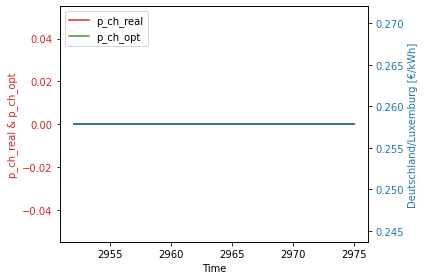

In [219]:
fig, ax1 = plt.subplots()



color1 = 'tab:red'
color2 = 'tab:green'
# First axis for p_ch_real and p_ch_opt
ax1.set_xlabel('Time')
ax1.set_ylabel('p_ch_real & p_ch_opt', color=color1)
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['p_ch_real'].iloc[day*24:(day+1)*24], color=color1, label='p_ch_real')
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['p_ch_opt'].iloc[day*24:(day+1)*24], color=color2, label='p_ch_opt')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
color3 = 'tab:blue'
ax2.set_ylabel('Deutschland/Luxemburg [€/kWh]', color=color3)
ax2.plot(temp_results.index[day*24:(day+1)*24], temp_results['Deutschland/Luxemburg [€/kWh]'].iloc[day*24:(day+1)*24], color=color3)
ax2.tick_params(axis='y', labelcolor=color3)

fig.tight_layout()  # for a neat layout
plt.show()



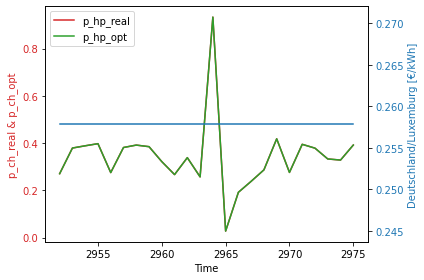

In [220]:
fig, ax1 = plt.subplots()



color1 = 'tab:red'
color2 = 'tab:green'
# First axis for p_ch_real and p_ch_opt
ax1.set_xlabel('Time')
ax1.set_ylabel('p_ch_real & p_ch_opt', color=color1)
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['p_hp_real'].iloc[day*24:(day+1)*24], color=color1, label='p_hp_real')
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['p_hp_opt'].iloc[day*24:(day+1)*24], color=color2, label='p_hp_opt')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
color3 = 'tab:blue'
ax2.set_ylabel('Deutschland/Luxemburg [€/kWh]', color=color3)
ax2.plot(temp_results.index[day*24:(day+1)*24], temp_results['Deutschland/Luxemburg [€/kWh]'].iloc[day*24:(day+1)*24], color=color3)
ax2.tick_params(axis='y', labelcolor=color3)

fig.tight_layout()  # for a neat layout
plt.show()



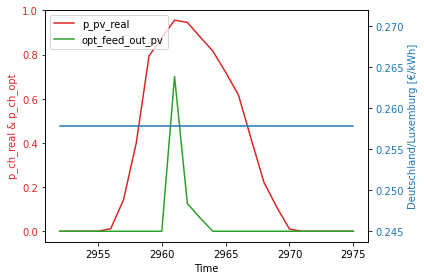

In [221]:
fig, ax1 = plt.subplots()



color1 = 'tab:red'
color2 = 'tab:green'
# First axis for p_ch_real and p_ch_opt
ax1.set_xlabel('Time')
ax1.set_ylabel('p_ch_real & p_ch_opt', color=color1)
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['p_pv'].iloc[day*24:(day+1)*24], color=color1, label='p_pv_real')
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['opt_feed_out_pv'].iloc[day*24:(day+1)*24], color=color2, label='opt_feed_out_pv')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
color3 = 'tab:blue'
ax2.set_ylabel('Deutschland/Luxemburg [€/kWh]', color=color3)
ax2.plot(temp_results.index[day*24:(day+1)*24], temp_results['Deutschland/Luxemburg [€/kWh]'].iloc[day*24:(day+1)*24], color=color3)
ax2.tick_params(axis='y', labelcolor=color3)

fig.tight_layout()  # for a neat layout
plt.show()



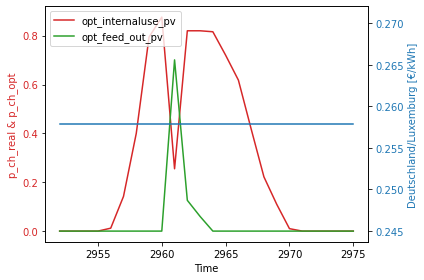

In [222]:
fig, ax1 = plt.subplots()



color1 = 'tab:red'
color2 = 'tab:green'
# First axis for p_ch_real and p_ch_opt
ax1.set_xlabel('Time')
ax1.set_ylabel('p_ch_real & p_ch_opt', color=color1)
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['opt_internaluse_pv'].iloc[day*24:(day+1)*24], color=color1, label='opt_internaluse_pv')
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['opt_feed_out_pv'].iloc[day*24:(day+1)*24], color=color2, label='opt_feed_out_pv')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
color3 = 'tab:blue'
ax2.set_ylabel('Deutschland/Luxemburg [€/kWh]', color=color3)
ax2.plot(temp_results.index[day*24:(day+1)*24], temp_results['Deutschland/Luxemburg [€/kWh]'].iloc[day*24:(day+1)*24], color=color3)
ax2.tick_params(axis='y', labelcolor=color3)

fig.tight_layout()  #  for a neat layout
plt.show()



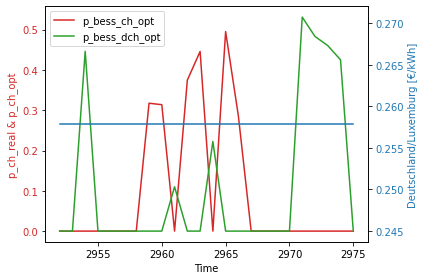

In [223]:
fig, ax1 = plt.subplots()



color1 = 'tab:red'
color2 = 'tab:green'
# First axis for p_ch_real and p_ch_opt
ax1.set_xlabel('Time')
ax1.set_ylabel('p_ch_real & p_ch_opt', color=color1)
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['p_bess_ch_opt'].iloc[day*24:(day+1)*24], color=color1, label='p_bess_ch_opt')
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['p_bess_dch_opt'].iloc[day*24:(day+1)*24], color=color2, label='p_bess_dch_opt')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
color3 = 'tab:blue'
ax2.set_ylabel('Deutschland/Luxemburg [€/kWh]', color=color3)
ax2.plot(temp_results.index[day*24:(day+1)*24], temp_results['Deutschland/Luxemburg [€/kWh]'].iloc[day*24:(day+1)*24], color=color3)
ax2.tick_params(axis='y', labelcolor=color3)

fig.tight_layout()  # for a neat layout
plt.show()





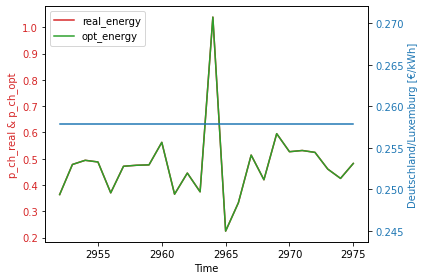

In [224]:
fig, ax1 = plt.subplots()



color1 = 'tab:red'
color2 = 'tab:green'
# First axis for p_ch_real and p_ch_opt
ax1.set_xlabel('Time')
ax1.set_ylabel('p_ch_real & p_ch_opt', color=color1)
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['real_energy'].iloc[day*24:(day+1)*24], color=color1, label='real_energy')
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['opt_energy'].iloc[day*24:(day+1)*24], color=color2, label='opt_energy')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
color3 = 'tab:blue'
ax2.set_ylabel('Deutschland/Luxemburg [€/kWh]', color=color3)
ax2.plot(temp_results.index[day*24:(day+1)*24], temp_results['Deutschland/Luxemburg [€/kWh]'].iloc[day*24:(day+1)*24], color=color3)
ax2.tick_params(axis='y', labelcolor=color3)

fig.tight_layout()  # for a neat layout
plt.show()





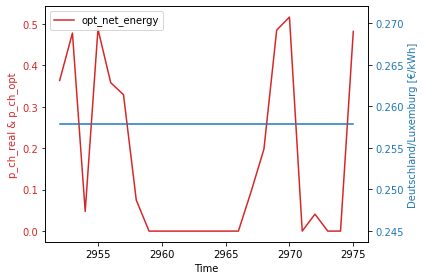

In [225]:
fig, ax1 = plt.subplots()



color1 = 'tab:red'
color2 = 'tab:green'
# First axis for p_ch_real and p_ch_opt
ax1.set_xlabel('Time')
ax1.set_ylabel('p_ch_real & p_ch_opt', color=color1)
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['opt_net_energy'].iloc[day*24:(day+1)*24], color=color1, label='opt_net_energy')
#ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['opt_energy'].iloc[day*24:(day+1)*24], color=color2, label='opt_energy')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
color3 = 'tab:blue'
ax2.set_ylabel('Deutschland/Luxemburg [€/kWh]', color=color3)
ax2.plot(temp_results.index[day*24:(day+1)*24], temp_results['Deutschland/Luxemburg [€/kWh]'].iloc[day*24:(day+1)*24], color=color3)
ax2.tick_params(axis='y', labelcolor=color3)

fig.tight_layout()  # for a neat layout
plt.show()





In [172]:
# Debugging

model.computeIIS()
model.write("model.ilp")



Computing Irreducible Inconsistent Subsystem (IIS)...

           Constraints          |            Bounds           |  Runtime
      Min       Max     Guess   |   Min       Max     Guess   |
--------------------------------------------------------------------------
        0    156948         -         0     87600         -           0s
       14        14         -         0         0         -           2s

IIS computed: 14 constraints, 0 bounds
IIS runtime: 1.82 seconds (0.33 work units)


In [161]:
household_config.iloc[:50]

,heat_pump_profile,household_profile,ev_col,ev_shift_weeks,bess_capacity,bess_power,pv_power
0,0_SFH19_P_TOT,0_SFH19_P_TOT,Bl7,48,10.0,4.100,10.0
1,1_SFH18_P_TOT,1_SFH18_P_TOT,AdO1,-24,7.5,3.075,7.5
2,2_SFH4_P_TOT,2_SFH4_P_TOT,UT2,-96,10.0,4.100,10.0
3,3_SFH30_P_TOT,3_SFH30_P_TOT,SR14,96,5.0,2.050,5.0
4,4_SFH3_P_TOT,4_SFH3_P_TOT,AdO1,-72,10.0,4.100,10.0
5,5_SFH3_P_TOT,5_SFH3_P_TOT,AsO6,-72,5.0,2.050,5.0
6,6_SFH12_P_TOT,6_SFH12_P_TOT,Bl2,48,2.5,1.025,2.5
7,7_SFH5_P_TOT,7_SFH5_P_TOT,AsO4,0,5.0,2.050,5.0
8,8_SFH18_P_TOT,8_SFH18_P_TOT,Bl2,96,7.5,3.075,7.5
9,9_SFH34_P_TOT,9_SFH34_P_TOT,NR1,72,10.0,4.100,10.0


In [ ]:
# Debugging 

if df_results.isna().any().any():
    columns_with_na = df_results.isna().any()
    columns_with_na_names = columns_with_na[columns_with_na].index.tolist()
    print(columns_with_na_names)
    
temp_ev_df = pd.DataFrame(ev_load)
temp_ev_df.index = pd.to_datetime(temp_ev_df.index)
temp_ev_df.resample("D").sum()

failed_hhs = []
transposed_config = household_config.T
for hh in columns_with_na_names:
    failed_hhs.append(transposed_config[int(hh)])
    
failed_hhs_df = pd.DataFrame(failed_hhs)


#household_config[household_config["heat_pump_profile"]=="148_SFH34_P_TOT"].index
for i in household_config.index:
    if household_config.index[i]==148:
        print(i)


failed_hhs_df